In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as model
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from scipy import stats
from datetime import date
import os.path
import pickle

# An unfinished module allowing for improved workflow with
# datasets sourced from the Gene Expression Omnibus.
import geo_tools as gt

In [2]:
# Soon to be part of geo_tools.
def process_data(GSE_list, info= "age"):
    
    """Takes in a list of GSEs, returns a corresponding X_df and y."""
    
    # making X
    GSE_df_dict = {}
    GSE_df_list = []

    for GSE in GSE_list:

        GSE_df = gt.series(GSE).transpose()

        # IDing with both GSE and GSM codes.
        multi_index_arrays = [[], []]
        for GSM in GSE_df.index:
            multi_index_arrays[0].append(GSE)
            multi_index_arrays[1].append(GSM)

        GSE_df.index =  pd.MultiIndex.from_arrays(multi_index_arrays)

        # Many datsets come with missing values.
        GSE_df.fillna(inplace= True, method= 'ffill')
        GSE_df.fillna(inplace= True, method= 'bfill')

        GSE_df_dict[GSE] = GSE_df
        GSE_df_list.append(GSE_df)

    X_df = pd.concat(GSE_df_list)

    # Let's manually remove the rows that still contain NaNs that
    # the pandas library wasn't able to deal with.
    samples_na = X_df.isna().any(axis= 1)

    for sample in samples_na.index:
        if samples_na.loc[sample]:
            X_df.drop(labels= sample, inplace= True)

    y = []
    for row in X_df.index:
        y.append(gt.info(row[0], row[1], info= info))
        
    index_arr = [re.match("cg", label) == None for label in X_df.columns]
    bad_labels = np.array(X_df.columns)[index_arr]
    
    X_df.drop(labels= bad_labels, axis= "columns", inplace= True)
            
    return X_df, y

In [3]:
temp_data_28k = ["GSE41037"]

In [4]:
temp_data_450k = ["GSE40279"]

In [5]:
temp_data_850k = ["GSE100825"]

In [6]:
temp_28k_X, _ = process_data(temp_data_28k)
temp_450k_X, _ = process_data(temp_data_450k)
temp_850k_X, _ = process_data(temp_data_850k)

In [7]:
CpG_set_28k = set(temp_28k_X.columns)
CpG_set_450k = set(temp_450k_X.columns)
CpG_set_850k = set(temp_850k_X.columns)

small_CpG_list = list(CpG_set_28k.intersection(CpG_set_450k).intersection(CpG_set_850k))
medium_CpG_list = list(CpG_set_450k.intersection(CpG_set_850k))
large_CpG_list = list(CpG_set_850k)

In [8]:
del temp_data_28k, temp_data_450k, temp_data_850k

In [9]:
del temp_28k_X, temp_450k_X, temp_850k_X

## The Small Model

In [10]:
small_data = ["GSE41037", "GSE20067", "GSE20236", "GSE19711"]

In [11]:
small_X, small_age = process_data(small_data)

In [12]:
small_X = small_X[small_CpG_list]

In [13]:
small_scaler = StandardScaler()

In [14]:
small_X_train, small_X_test, small_age_train, small_age_test = train_test_split(small_X, small_age, test_size= 0.20)

In [15]:
small_X_train = small_scaler.fit_transform(small_X_train)
small_X_test = small_scaler.transform(small_X_test)

In [16]:
# For the reader's sake, we provide the hyperparameters determined by the following two lines.
# small_model = model.ElasticNetCV(l1_ratio= [0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99], selection= "random")
# small_model.fit(small_X_train, small_age_train)

# alpha= 0.3258451445804574
# l1_ratio= 0.4

small_model = model.ElasticNet(alpha= 0.3258451445804574, l1_ratio= 0.4)
small_model.fit(small_X_train, small_age_train)

C:\Users\blanc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e+03, tolerance: 4.758e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.3258451445804574, l1_ratio=0.4)

In [17]:
small_X_test_predict = small_model.predict(small_X_test)

In [18]:
FIGURES_DIR = "./final_clock_figures/"
if not os.path.exists(FIGURES_DIR):
    os.mkdir(FIGURES_DIR)

In [19]:
def finalize_scatter_plot(x, y, model_name, file_name):
    r = stats.pearsonr(x, y)[0]
    mae_val = mae(x, y)
    plt.title(f"DNAm pred. vs actual age\n{model_name}\nr= {r}\nMAE= {mae_val}", loc= "right")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    accuracy_line = [0, 100]
    plt.plot(accuracy_line, accuracy_line, ls= "--", color= "black")
    plt.xlabel("actual age", fontsize= 15)
    plt.ylabel("DNAm predicted age", fontsize= 15)
    plt.legend()
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 15)
    plt.savefig(fname= f"{file_name}", bbox_inches= "tight", dpi= 600)
    plt.show()

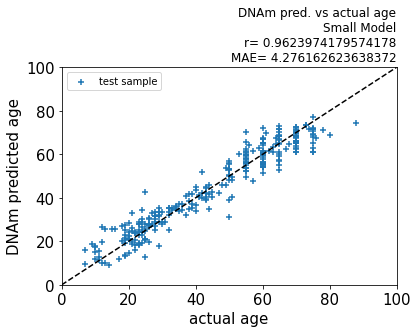

In [20]:
plt.scatter(small_age_test, small_X_test_predict, label= "test sample", marker= "+")
small_file_name = os.path.join(FIGURES_DIR, "small_model_test")
finalize_scatter_plot(small_age_test, small_X_test_predict, "Small Model", small_file_name)

## The Medium Model

In [21]:
medium_data = ["GSE40279"]

In [22]:
medium_X, medium_age = process_data(medium_data)

In [23]:
medium_X = medium_X[medium_CpG_list]

In [24]:
medium_indices_to_cpg_labels = dict()
index = 0
for cpg in medium_X.columns:
    medium_indices_to_cpg_labels[index] = cpg
    index += 1
medium_indices_to_cpg_labels

{0: 'cg12900082',
 1: 'cg01149192',
 2: 'cg11843735',
 3: 'cg13182731',
 4: 'cg21665905',
 5: 'cg00943124',
 6: 'cg24416910',
 7: 'cg23244398',
 8: 'cg23404610',
 9: 'cg03295083',
 10: 'cg01870580',
 11: 'cg24143221',
 12: 'cg25017060',
 13: 'cg05895353',
 14: 'cg07589968',
 15: 'cg21331362',
 16: 'cg16069986',
 17: 'cg18191867',
 18: 'cg22880392',
 19: 'cg14157930',
 20: 'cg25029529',
 21: 'cg22772300',
 22: 'cg05851442',
 23: 'cg11959894',
 24: 'cg18080858',
 25: 'cg04258973',
 26: 'cg07544189',
 27: 'cg00735591',
 28: 'cg13847858',
 29: 'cg07537287',
 30: 'cg15084499',
 31: 'cg02115117',
 32: 'cg25333257',
 33: 'cg14282850',
 34: 'cg17651821',
 35: 'cg20132003',
 36: 'cg22384010',
 37: 'cg13774015',
 38: 'cg24993576',
 39: 'cg14531663',
 40: 'cg06141561',
 41: 'cg01643997',
 42: 'cg10453123',
 43: 'cg26742989',
 44: 'cg11537447',
 45: 'cg03564009',
 46: 'cg02187712',
 47: 'cg06720082',
 48: 'cg10052190',
 49: 'cg12113984',
 50: 'cg14412622',
 51: 'cg25276521',
 52: 'cg21301655',
 53

In [25]:
medium_scaler = StandardScaler()

In [26]:
medium_X_train, medium_X_test, medium_age_train, medium_age_test = train_test_split(medium_X, medium_age, test_size= 0.20)

In [27]:
medium_X_train = medium_scaler.fit_transform(medium_X_train)
medium_X_test = medium_scaler.transform(medium_X_test)

In [28]:
# For the reader's sake, we provide the hyperparameters determined by the following two lines.
# medium_model = model.ElasticNetCV(l1_ratio= [0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99], selection= "random")
# medium_model.fit(medium_X_train, medium_age_train)

# alpha= 0.06470723076032536
# l1_ratio= 0.2

medium_model = model.ElasticNet(alpha= 0.06470723076032536, l1_ratio= 0.2)
medium_model.fit(medium_X_train, medium_age_train)

C:\Users\blanc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e+02, tolerance: 1.123e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.06470723076032536, l1_ratio=0.2)

In [29]:
medium_X_test_predict = medium_model.predict(medium_X_test)

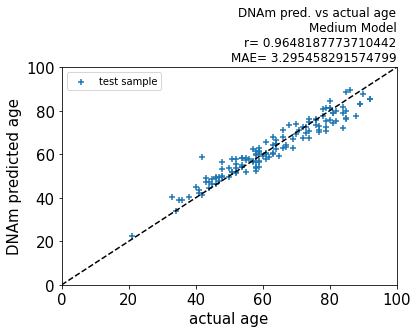

In [30]:
plt.scatter(medium_age_test, medium_X_test_predict, label= "test sample", marker= "+")
medium_file_name = os.path.join(FIGURES_DIR, "medium_model_test")
finalize_scatter_plot(medium_age_test, medium_X_test_predict, "Medium Model", medium_file_name)

In [34]:
medium_model_non_zero_cpg_indices = get_non_zero_cpgs_indices(medium_model)

In [36]:
medium_model_non_zero_cpg_labels = []
for i in medium_model_non_zero_cpg_indices:
    label = medium_indices_to_cpg_labels[i]
    medium_model_non_zero_cpg_labels.append(label)

medium_model_non_zero_cpg_labels, len(medium_model_non_zero_cpg_labels)

(['cg13196652',
  'cg01077178',
  'cg04500819',
  'cg11653233',
  'cg20367218',
  'cg06392169',
  'cg16966496',
  'cg10120818',
  'cg19988763',
  'cg09216143',
  'cg11179513',
  'cg02359433',
  'cg13686013',
  'cg19998835',
  'cg22214854',
  'cg01348121',
  'cg07920503',
  'cg23402755',
  'cg18279742',
  'cg09981029',
  'cg24526694',
  'cg24087613',
  'cg07850604',
  'cg09270514',
  'cg11678206',
  'cg12287936',
  'cg16294280',
  'cg27034568',
  'cg00697970',
  'cg25441338',
  'cg24566824',
  'cg17246929',
  'cg15195541',
  'cg05225909',
  'cg22092014',
  'cg01102833',
  'cg22171145',
  'cg08808811',
  'cg16377738',
  'cg23634566',
  'cg03721175',
  'cg13632058',
  'cg20045045',
  'cg25137365',
  'cg17034331',
  'cg04835652',
  'cg14074174',
  'cg27074995',
  'cg11746498',
  'cg18801825',
  'cg00515905',
  'cg01966966',
  'cg08902940',
  'cg23950232',
  'cg16513459',
  'cg10804656',
  'cg25456477',
  'cg25674883',
  'cg22990198',
  'cg00151728',
  'cg13663218',
  'cg04399615',
  'cg178

In [37]:
d = {"label": medium_model_non_zero_cpg_labels}
medium_model_non_zero_cpg_labels_df = pd.DataFrame(data=d)
medium_model_non_zero_cpg_labels_df.head(5)

,label
0,cg13196652
1,cg01077178
2,cg04500819
3,cg11653233
4,cg20367218


In [39]:
medium_model_non_zero_cpg_labels_df.to_csv("1st_gen_medium_model_cpg_labels.csv")

In [40]:
len(medium_model.coef_), len(medium_CpG_list)

(438866, 438866)

### let's test with data that serafina sent me

### normal - from parkinsons dataset

In [256]:
norm_park_file = open("./norm_park.pickle", mode= "rb")

In [257]:
norm_park_df = pickle.load(norm_park_file)
norm_park_df

CpG,cg00050873,cg00212031,cg00213748,cg00214611,cg00455876,cg01707559,cg02004872,cg02011394,cg02050847,cg02233190,...,ch.22.757911F,ch.22.772318F,ch.22.43177094F,ch.22.44116734F,ch.22.909671F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R,age
GSM1870442,0.617958,0.106996,0.407407,0.628641,0.353630,0.194396,0.347648,0.278237,0.780220,0.275424,...,0.063668,0.037344,0.022905,0.019546,0.084579,0.031513,0.000000,0.056514,0.040605,46.2
GSM1870444,0.905573,0.043592,0.929293,0.027136,0.786912,0.059142,0.011283,0.979937,0.991415,0.008888,...,0.028379,0.000000,0.023791,0.020185,0.065217,0.040842,0.004047,0.082611,0.026445,66.0
GSM1870448,0.683662,0.588991,0.571429,0.665605,0.368169,0.240189,0.287415,0.616319,0.529644,0.378182,...,0.072249,0.060493,0.035779,0.039078,0.161660,0.043024,0.026266,0.081895,0.031115,41.4
GSM1870449,0.720047,0.587326,0.329815,0.579035,0.314706,0.221817,0.276821,0.770335,0.771242,0.329932,...,0.049327,0.039718,0.023200,0.022495,0.114537,0.030857,0.009938,0.076930,0.028283,42.4
GSM1870451,0.813653,0.733032,0.029851,0.641753,0.174355,0.233090,0.268238,0.390710,0.198582,0.273859,...,0.069857,0.000000,0.032603,0.044948,0.294182,0.044515,0.037855,0.103224,0.169995,63.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1870929,0.886310,0.011666,0.958854,0.039579,0.867166,0.096141,0.008929,0.980048,0.991842,0.009966,...,0.064122,0.032886,0.023452,0.029602,0.131469,0.035842,0.009412,0.068702,0.032304,69.0
GSM1870930,0.887328,0.271781,0.795495,0.086174,0.714430,0.227080,0.023411,0.989507,0.990316,0.015801,...,0.034828,0.010638,0.023779,0.029187,0.102105,0.032375,0.011446,0.070895,0.030025,79.2
GSM1870931,0.901840,0.430000,0.792651,0.384921,0.329762,0.265560,0.308463,0.260465,1.000000,0.155080,...,0.048151,0.035985,0.016972,0.005120,0.098720,0.036990,0.012647,0.075345,0.026455,70.8
GSM1870937,0.848921,0.023980,0.865091,0.029088,0.788560,0.033080,0.009011,0.964662,0.987890,0.021610,...,0.029949,0.053398,0.016910,0.029915,0.092113,0.040103,0.002783,0.061905,0.031029,72.1


In [258]:
norm_ages = np.array(norm_park_df["age"])

In [259]:
norm_park_df = norm_park_df[medium_CpG_list]

In [260]:
norm_park_df = norm_park_df.iloc[:, filtered_cpgs_ints]
len(norm_park_df.columns)

139

In [261]:
norm_park_df = norm_park_df.fillna(method= "pad")

In [262]:
norm_park_df = medium_global_temp_cpgs_scaler.transform(norm_park_df)
norm_park_df

array([[ 0.89630024, -0.63876108, -0.9316924 , ..., -0.41480177,
         1.67722834, -0.29691232],
       [ 0.19149627, -1.18778336,  0.33593987, ..., -0.66190527,
         0.70847725, -0.79665049],
       [ 0.86496281,  0.41268391, -0.8345787 , ..., -1.00388412,
         1.13107228, -0.57679901],
       ...,
       [ 0.37680816,  0.9127488 ,  0.88315795, ...,  0.16384989,
         1.21232427, -0.04199962],
       [ 0.85122272, -0.5802368 ,  1.34918725, ...,  0.09331967,
         1.9907328 , -0.36128434],
       [ 1.71962553,  0.4056749 , -0.36549927, ..., -0.12163051,
         0.54559577, -0.01112232]])

In [263]:
norm_park_age_pred = medium_model_global_temp_cpgs.predict(norm_park_df)

In [264]:
type(norm_park_age_pred)

numpy.ndarray

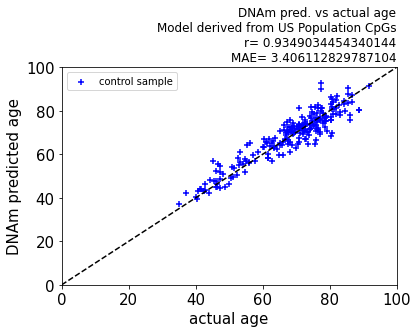

In [265]:
plt.scatter(norm_ages, norm_park_age_pred, label= "control sample", marker= "+", color= "blue")
us_pop_norm_parkinsons_file_name = os.path.join(FIGURES_DIR, "us_pop_derived_medium_model_parkinsons_control_test")
finalize_scatter_plot(norm_ages, norm_park_age_pred, "Model derived from US Population CpGs", us_pop_norm_parkinsons_file_name)

In [266]:
d = {"pred_age": norm_park_age_pred, "actual_age": norm_ages}
d

{'pred_age': array([47.67491976, 65.7278783 , 44.01520425, 43.02746229, 63.02952539,
        73.35320004, 43.99563035, 56.89396659, 59.63243985, 73.21165955,
        42.96593648, 74.66267111, 42.13511033, 46.1597652 , 71.0093575 ,
        37.13130331, 48.31954402, 66.56806332, 42.08031351, 48.75918716,
        81.31143128, 47.52419936, 52.12619813, 65.31913726, 65.56729984,
        83.73355511, 40.3393463 , 57.12256518, 55.75626804, 72.09199897,
        39.4563403 , 54.56427247, 43.36290003, 44.96217424, 44.88233223,
        44.54080981, 43.6284118 , 46.13872055, 51.80892248, 75.73315977,
        67.1867552 , 69.78738354, 73.70778264, 75.38413864, 87.70784792,
        73.37234971, 77.23420798, 61.25101035, 82.84133132, 73.81018273,
        64.11806531, 72.58214529, 58.38386176, 77.49951082, 71.66895561,
        55.21017522, 73.52983223, 62.88864164, 83.08538935, 71.20806291,
        65.04934946, 50.96583957, 58.21722604, 70.61421395, 67.71644757,
        65.97176278, 71.50360089, 76.79

In [267]:
norm_park_results = pd.DataFrame(data= d)
norm_park_results

,pred_age,actual_age
0,47.674920,46.2
1,65.727878,66.0
2,44.015204,41.4
3,43.027462,42.4
4,63.029525,63.4
...,...,...
214,69.253033,69.0
215,70.832873,79.2
216,72.726501,70.8
217,72.789177,72.1


In [268]:
norm_park_results.to_csv("./control_parkinsons_results_gen_2.csv")

### diseased samples - from parkinsons dataset

In [269]:
dis_park_file = open("./dis_park.pickle", mode= "rb")

In [270]:
dis_park_df = pickle.load(dis_park_file)
dis_park_df

CpG,cg00050873,cg00212031,cg00213748,cg00214611,cg00455876,cg01707559,cg02004872,cg02011394,cg02050847,cg02233190,...,ch.22.757911F,ch.22.772318F,ch.22.43177094F,ch.22.44116734F,ch.22.909671F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R,age
GSM1870443,0.913606,0.031610,0.887772,0.030347,0.828235,0.074542,0.012769,0.974279,0.974380,0.016332,...,0.070380,0.090066,0.025716,0.043278,0.081661,0.032390,0.000000,0.078346,0.025193,64.9
GSM1870445,0.934630,0.063161,0.819123,0.047765,0.817258,0.088820,0.006576,0.982853,0.974730,0.026380,...,0.035852,0.041446,0.016745,0.031642,0.222222,0.028299,0.016028,0.065336,0.032267,72.3
GSM1870446,0.914863,0.021233,0.984434,0.017082,0.859086,0.091052,0.008037,0.963489,0.992266,0.009336,...,0.059129,0.020105,0.016301,0.014092,0.116181,0.026703,0.012826,0.059966,0.027933,70.1
GSM1870447,0.906161,0.035838,0.875760,0.039167,0.838594,0.088298,0.010643,0.975971,0.993456,0.060835,...,0.038975,0.010050,0.026842,0.005008,0.088160,0.031989,0.012070,0.064562,0.035966,75.4
GSM1870450,0.886562,0.055194,0.889080,0.054183,0.849151,0.044983,0.015784,0.958615,0.985702,0.043565,...,0.017149,0.073982,0.015143,0.023421,0.147722,0.030172,0.009482,0.076767,0.033681,49.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1870945,0.865308,0.063223,0.831964,0.041964,0.741389,0.149531,0.013054,0.975016,0.988575,0.013505,...,0.031327,0.024783,0.021695,0.019415,0.109388,0.031709,0.018646,0.064733,0.027018,82.5
GSM1870946,0.889137,0.025573,0.959322,0.047944,0.755842,0.096975,0.015599,0.959164,0.980864,0.016453,...,0.063247,0.006222,0.019209,0.041359,0.177348,0.030336,0.016851,0.076767,0.041022,67.9
GSM1870947,0.864277,0.028845,0.909585,0.028520,0.680628,0.084075,0.011482,0.963205,0.982094,0.038492,...,0.068984,0.044964,0.030311,0.021311,0.217198,0.039325,0.013696,0.081025,0.149625,76.1
GSM1870948,0.854018,0.041094,0.865546,0.044286,0.751671,0.070170,0.008029,0.975707,0.995870,0.013638,...,0.059144,0.002210,0.031029,0.030718,0.165429,0.048185,0.010391,0.090366,0.048505,58.7


In [271]:
dis_ages = np.array(dis_park_df["age"])

In [272]:
dis_park_df = dis_park_df[medium_CpG_list]

In [273]:
dis_park_df = dis_park_df.iloc[:, filtered_cpgs_ints]
len(dis_park_df.columns)

139

In [274]:
dis_park_df = dis_park_df.fillna(method= "pad")

In [275]:
dis_park_df = medium_global_temp_cpgs_scaler.transform(dis_park_df)
dis_park_df

array([[ 1.79241364,  0.09384117, -0.06997612, ..., -0.74261746,
         0.86992973, -1.18635413],
       [-1.18233516,  5.03477786,  1.18845877, ...,  0.72587749,
         1.88690387, -0.37278855],
       [-1.00701192, -1.24568275, -1.10788476, ..., -0.81546719,
         1.46419618, -2.27483169],
       ...,
       [-0.50696487, -0.50238859, -0.16818827, ...,  1.17467871,
         1.19164433,  0.83338977],
       [ 0.07639112,  1.22422922,  0.03339428, ..., -0.25086074,
         0.64874113,  0.69892217],
       [ 1.14405596,  0.01734641, -0.47313583, ...,  0.12250838,
         0.85453772,  0.99786826]])

In [276]:
dis_park_age_pred = medium_model_global_temp_cpgs.predict(dis_park_df)

In [277]:
type(dis_park_age_pred)

numpy.ndarray

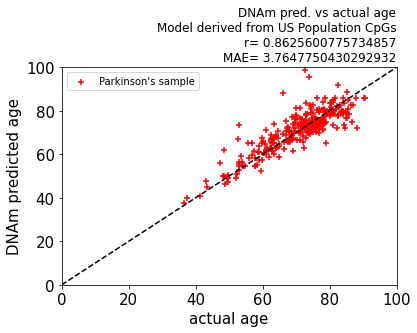

In [278]:
plt.scatter(dis_ages, dis_park_age_pred, label= "Parkinson's sample", marker= "+", color= "red")
medium_parkinsons_file_name = os.path.join(FIGURES_DIR, "us_pop_derived_medium_model_parkinsons_test")
finalize_scatter_plot(dis_ages, dis_park_age_pred, "Model derived from US Population CpGs", medium_parkinsons_file_name)

In [279]:
d = {"pred_age": dis_park_age_pred, "actual_age": dis_ages}
d

{'pred_age': array([58.72878239, 73.62357801, 78.13127796, 75.09475099, 49.32362812,
        74.44143291, 74.26279755, 75.56986733, 79.97575582, 40.0155918 ,
        45.19784332, 50.179185  , 52.12293032, 76.18357198, 73.3106285 ,
        37.7812669 , 61.7798748 , 49.2215961 , 68.98644017, 66.07372745,
        69.65562017, 46.55127519, 66.55453154, 47.7200826 , 63.18070255,
        73.61848859, 70.26952618, 40.82415974, 49.85701719, 65.78353024,
        95.39710175, 62.91662609, 74.40241059, 55.9686908 , 66.99702306,
        56.46125191, 65.19823949, 80.68925819, 62.94468406, 72.1229426 ,
        67.61368761, 82.79794755, 78.36881567, 76.4226945 , 76.61653881,
        54.74650475, 74.6964929 , 69.45119981, 73.34944087, 56.38596428,
        82.90425024, 82.0394782 , 81.22240574, 72.69163026, 75.13045999,
        62.24035506, 55.1552429 , 67.11385517, 71.9056534 , 75.97005328,
        75.74073883, 77.46227448, 71.24763394, 77.47681423, 65.12689057,
        98.69052329, 62.76515396, 79.30

In [280]:
parkinsons_results = pd.DataFrame(data= d)
parkinsons_results

,pred_age,actual_age
0,58.728782,64.9
1,73.623578,72.3
2,78.131278,70.1
3,75.094751,75.4
4,49.323628,49.3
...,...,...
284,78.224958,82.5
285,66.183801,67.9
286,75.285560,76.1
287,61.059659,58.7


In [281]:
parkinsons_results.to_csv("./dis_park_results_gen_2.csv")

## MS

In [282]:
ms_file = open("./MS.pickle", mode= "rb")

In [283]:
ms_df = pickle.load(ms_file)
ms_df

ID_REF,cg00050873,cg00212031,cg00213748,cg00214611,cg00455876,cg01707559,cg02004872,cg02011394,cg02050847,cg02233190,...,ch.22.772318F,ch.22.43177094F,ch.22.44116734F,ch.22.909671F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R,status,age
GSM2844230,0.839022,0.048544,0.929552,0.003926,0.749837,0.128048,0.028353,0.978356,0.986783,0.060748,...,0.040112,0.020897,0.038777,0.063337,0.031579,0.019584,0.069147,0.042516,MS case,27
GSM2844231,0.827670,0.023571,0.885595,0.025893,0.776317,0.061251,0.026532,0.969593,0.985900,0.102235,...,0.036081,0.030065,0.045512,0.056807,0.036067,0.025031,0.061327,0.049633,MS case,22
GSM2844232,0.854833,0.022507,0.904054,0.035589,0.743004,0.064458,0.011640,0.964500,0.984757,0.020528,...,0.031520,0.025355,0.032146,0.068479,0.038705,0.015935,0.072619,0.038305,MS case,40
GSM2844233,0.835063,0.049974,0.885727,0.016293,0.738959,0.082177,0.021536,0.949293,0.974093,0.023232,...,0.045499,0.025027,0.036216,0.061869,0.034526,0.017267,0.081382,0.141724,MS case,55
GSM2844234,0.678832,0.428358,0.218989,0.551188,0.318253,0.295278,0.259824,0.670558,0.508221,0.319328,...,0.043728,0.042064,0.055437,0.060685,0.038003,0.030012,0.095796,0.043548,MS case,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2844550,0.231481,0.357143,0.513274,0.390306,0.353832,0.282785,0.280322,0.779037,0.256696,0.348045,...,0.076883,0.034393,0.054491,0.070566,0.057715,0.054401,0.113083,0.065653,Healthy control,37
GSM2844551,0.406433,0.285714,0.393094,0.443103,0.192647,0.326143,0.307576,0.562620,0.609572,0.312785,...,0.060476,0.045253,0.056952,0.106683,0.056757,0.046410,0.099349,0.182324,MS case,48
GSM2844552,0.678400,0.538462,0.184896,0.587814,0.404339,0.246351,0.208647,0.713068,0.492537,0.357895,...,0.065562,0.034330,0.077062,0.110688,0.052553,0.041486,0.092338,0.048637,MS case,23
GSM2844553,0.572016,0.424107,0.555938,0.548507,0.278761,0.320071,0.363839,0.564254,0.307339,0.323960,...,0.064215,0.044951,0.053600,0.111438,0.054215,0.044541,0.092774,0.071762,Healthy control,54


In [284]:
ms_ages = np.array(ms_df["age"])
for i in range(len(ms_ages)):
    ms_ages[i] = int(ms_ages[i])

disease_status = np.array(ms_df["status"])

In [285]:
healthy_ind = []
ms_ind = []

for s in disease_status:
    if s == "Healthy control":
        healthy_ind.append(True)
        ms_ind.append(False)
    elif s == "MS case":
        healthy_ind.append(False)
        ms_ind.append(True)
    else:
        print("missing one")

In [286]:
ms_df = ms_df[medium_CpG_list]

In [287]:
ms_df = ms_df.iloc[:, filtered_cpgs_ints]
len(ms_df.columns)

139

In [288]:
ms_df = ms_df.fillna(method= "bfill")
ms_df = ms_df.fillna(method= "ffill")

In [289]:
ms_df = medium_global_temp_cpgs_scaler.transform(ms_df)
ms_df

array([[-1.22695081,  1.69781242, -1.88358072, ...,  0.044667  ,
         0.51321264, -1.26582672],
       [-1.81574057,  0.90705653, -2.50008279, ..., -0.76814137,
        -0.61158826, -1.11947922],
       [-0.82880695,  0.42516638, -2.48432617, ..., -0.38232724,
         0.066574  , -1.2325219 ],
       ...,
       [ 1.10772823,  2.37535624, -0.63547925, ..., -0.36750374,
         1.28622173,  0.02572431],
       [ 0.30602484,  0.68839532,  0.1505159 , ...,  0.2234991 ,
         1.91104229, -0.13394493],
       [ 0.47443756,  1.24928089, -0.09374628, ...,  0.01759046,
         1.53665639, -0.34383724]])

In [290]:
ms_age_pred = medium_model_global_temp_cpgs.predict(ms_df)

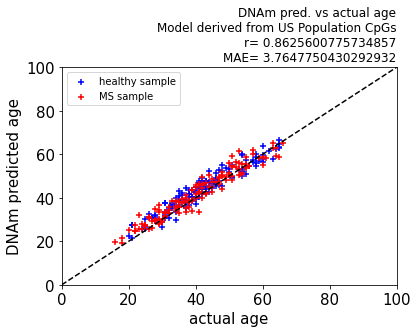

In [291]:
plt.scatter(ms_ages[healthy_ind], ms_age_pred[healthy_ind], label= "healthy sample", marker= "+", color= "blue")
plt.scatter(ms_ages[ms_ind], ms_age_pred[ms_ind], label= "MS sample", marker= "+", color= "red")

medium_MS_file_name = os.path.join(FIGURES_DIR, "gen_2_medium_model_MS_test")
finalize_scatter_plot(dis_ages, dis_park_age_pred, "Model derived from US Population CpGs", medium_MS_file_name)

In [292]:
d = {"pred_age": ms_age_pred, "actual_age": ms_ages}
d

{'pred_age': array([29.27109549, 24.81982756, 41.71515912, 53.57570778, 42.00986132,
        35.8231727 , 53.17909719, 49.40743677, 37.40128459, 46.53837622,
        61.58633137, 29.08686805, 41.54992283, 43.80864604, 57.20523103,
        57.66940352, 46.75231317, 46.87589802, 53.59095663, 56.37310478,
        52.37583389, 50.88869594, 53.39137374, 42.26421767, 51.9240329 ,
        29.14238893, 45.16126808, 39.61590715, 27.35758846, 35.45113603,
        38.45928912, 47.08639637, 32.25755141, 46.94005307, 19.16821151,
        42.57723434, 38.24629594, 43.75812506, 37.54533172, 39.76797467,
        44.12760743, 30.71710533, 35.74018306, 48.9676689 , 40.56237277,
        36.73471495, 60.27183534, 32.62708423, 62.08058203, 47.1678619 ,
        46.19384499, 21.57038254, 31.08824034, 47.47661087, 29.59250223,
        27.47916363, 48.32326198, 43.7683459 , 55.75437107, 33.94864633,
        38.32733152, 56.06742051, 42.04416881, 33.59293757, 38.78053256,
        29.65534208, 63.75836413, 54.48

In [293]:
ms_results = pd.DataFrame(data= d)
ms_results

,pred_age,actual_age
0,29.271095,27
1,24.819828,22
2,41.715159,40
3,53.575708,55
4,42.009861,43
...,...,...
274,35.587265,37
275,50.591464,48
276,32.305933,23
277,59.874851,54


In [294]:
ms_results.to_csv("./MS_results_gen_2.csv")

### werner syndrome

In [295]:
werner_file = open("./Werner_Syndrome.pickle", mode= "rb")

In [296]:
werner_df = pickle.load(werner_file)
werner_df

ID_REF                cg00000029  cg00000103  cg00000109  cg00000155  \
GSE100825 GSM2694066    0.646562    0.878838    0.905579    0.925186   
          GSM2694067    0.538249    0.902410    0.904032    0.934665   
          GSM2694068    0.527190    0.898359    0.885479    0.925673   
          GSM2694069    0.516348    0.884633    0.882224    0.920914   
          GSM2694070    0.421783    0.877394    0.884108    0.903828   
          GSM2694071    0.563347    0.877676    0.902442    0.930035   

ID_REF                cg00000158  cg00000165  cg00000221  cg00000236  \
GSE100825 GSM2694066    0.932245    0.106970    0.861418    0.761809   
          GSM2694067    0.935280    0.113383    0.886281    0.785804   
          GSM2694068    0.941409    0.150861    0.866107    0.832197   
          GSM2694069    0.937409    0.059281    0.887977    0.712423   
          GSM2694070    0.932568    0.095332    0.872783    0.737723   
          GSM2694071    0.912951    0.124959    0.901731    0.752412   

ID_REF                cg00000289  cg00000292  ...  cg27665913  cg27665925  \
GSE100825 GSM2694066    0.778761    0.811275  ...    0.900759    0.011261   
          GSM2694067    0.777328    0.815536  ...    0.918351    0.012891   
          GSM2694068    0.737792    0.836610  ...    0.910301    0.012986   
          GSM2694069    0.834136    0.788549  ...    0.897614    0.012966   
          GSM2694070    0.791135    0.841383  ...    0.921618    0.012990   
          GSM2694071    0.797080    0.806697  ...    0.920886    0.012712   

ID_REF                cg27665978  cg27665985  cg27666046  cg27666049  \
GSE100825 GSM2694066    0.844620    0.244657    0.564599    0.868386   
          GSM2694067    0.859105    0.341572    0.555774    0.816575   
          GSM2694068    0.834268    0.404887    0.388906    0.841959   
          GSM2694069    0.876654    0.250914    0.710208    0.844317   
          GSM2694070    0.862241    0.274147    0.572511    0.891965   
          GSM2694071    0.860147    0.265730    0.579267    0.890517   

ID_REF                cg27666060  cg27666108  cg27666123   age  
GSE100825 GSM2694066    0.824801    0.233204    0.839785  51.0  
          GSM2694067    0.831095    0.270234    0.863915  44.0  
          GSM2694068    0.825738    0.293093    0.796659  53.0  
          GSM2694069    0.873103    0.244478    0.852989  53.0  
          GSM2694070    0.828678    0.248083    0.849475  44.0  
          GSM2694071    0.847140    0.312648    0.882008  52.0  

[6 rows x 863905 columns]

In [297]:
werner_ages = np.array(werner_df["age"])

In [298]:
werner_df = werner_df[medium_CpG_list]

In [299]:
werner_df = werner_df.iloc[:, filtered_cpgs_ints]
len(werner_df.columns)

139

In [300]:
werner_df = werner_df.fillna(method= "pad")

In [301]:
werner_df = medium_global_temp_cpgs_scaler.transform(werner_df)
werner_df

array([[ 5.18477261e-01, -9.89436026e-01, -1.06681610e+00,
        -1.80417551e+00, -1.62316467e+00,  3.58386595e+00,
        -3.44395287e-01,  6.90797276e-01, -9.45049864e-02,
        -1.52490612e+00,  3.69099560e+00,  8.91641697e-01,
        -1.31569262e+00, -2.31835351e+00, -1.23289209e-01,
         2.28820128e-01, -2.35844696e+00, -1.19814633e+00,
         3.05628382e-01, -1.30702893e+00,  3.68767198e-01,
        -5.88385904e-01,  7.08202246e-01, -3.83156201e+00,
         2.21174401e+00, -1.69671091e+00,  1.21912038e+00,
         1.15175442e+00, -4.03848910e-01, -5.54164405e-01,
        -2.00969520e+00, -2.35496435e+00, -1.17929551e+00,
         1.94250084e+00, -2.51912338e+00,  1.14349076e+00,
        -1.31411721e+00,  2.31897396e+00, -1.54636065e+00,
        -1.17180782e+00, -2.50381141e+00,  1.83270905e-01,
         2.32909441e-01, -5.03437820e-01,  7.55124002e-01,
         1.38255482e+00, -1.54940799e+00, -1.49061561e+00,
        -1.37862847e+00, -2.13996239e+00, -3.51258231e+0

In [302]:
werner_age_pred = medium_model_global_temp_cpgs.predict(werner_df)

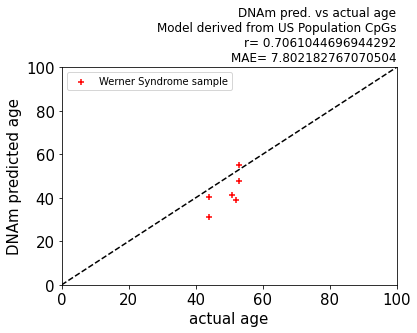

In [303]:
plt.scatter(werner_ages, werner_age_pred, label= "Werner Syndrome sample", marker= "+", color= "red")
us_pop_werner_filename = os.path.join(FIGURES_DIR, "us_pop_derived_medium_model_werner_syndrome_test")
finalize_scatter_plot(werner_ages, werner_age_pred, "Model derived from US Population CpGs", us_pop_werner_filename)

In [304]:
d = {"pred_age": werner_age_pred, "actual_age": werner_ages}
d

{'pred_age': array([41.35824289, 30.98898723, 47.82245849, 55.28890054, 40.52800687,
        38.77810845]),
 'actual_age': array([51., 44., 53., 53., 44., 52.])}

In [305]:
werner_results = pd.DataFrame(data= d)
werner_results

,pred_age,actual_age
0,41.358243,51.0
1,30.988987,44.0
2,47.822458,53.0
3,55.288901,53.0
4,40.528007,44.0
5,38.778108,52.0


In [306]:
werner_results.to_csv("./werner_syndrome_results_gen_2.csv")

### IBS

In [307]:
ibs_file = open("./IBS.pkl", mode= "rb")

In [308]:
ibs_df = pickle.load(ibs_file)
ibs_df

ID_REF,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,rs7746156,rs798149,rs845016,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367,rs9839873
GSM2336818,0.484840,0.904301,0.706628,0.268115,0.696812,0.552807,0.731842,0.355477,0.351903,0.045642,...,0.553988,0.477160,0.555363,0.532696,0.508120,0.259912,0.557469,0.902920,0.806501,0.722293
GSM2336819,0.549209,0.899991,0.757192,0.254714,0.782396,0.537098,0.826841,0.343745,0.383886,0.043136,...,0.542820,0.944774,0.485624,0.942371,0.488452,0.855391,0.581672,0.922380,0.817588,0.797783
GSM2336820,0.665182,0.910282,0.814520,0.241178,0.776249,0.676952,0.871598,0.327974,0.418875,0.040509,...,0.672129,0.056950,0.693259,0.540354,0.637202,0.640432,0.578289,0.566337,0.387525,0.860193
GSM2336821,0.536237,0.898268,0.796119,0.244020,0.723803,0.561323,0.829576,0.283472,0.408616,0.046047,...,0.932671,0.065737,0.522881,0.536366,0.920109,0.113204,0.602383,0.079792,0.571661,0.848829
GSM2336822,0.450374,0.906696,0.776311,0.250357,0.726807,0.578344,0.777413,0.261513,0.396494,0.044639,...,0.541303,0.059852,0.524525,0.940133,0.469027,0.596338,0.561113,0.522132,0.610090,0.641714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2337053,0.754166,0.924941,0.826363,0.278728,0.859885,0.658426,0.895978,0.461872,0.472104,0.043561,...,0.535310,0.061385,0.470220,0.608104,0.535429,0.111257,0.916240,0.492598,0.159320,0.703948
GSM2337054,0.544069,0.922609,0.834624,0.280992,0.713173,0.659256,0.802371,0.300417,0.427558,0.051920,...,0.529538,0.460318,0.136502,0.945212,0.530844,0.899833,0.105268,0.516616,0.168397,0.856872
GSM2337055,0.574472,0.930687,0.836744,0.268772,0.769004,0.707079,0.853384,0.290878,0.466079,0.057271,...,0.070562,0.947828,0.114142,0.063007,0.060613,0.580962,0.604596,0.070221,0.543221,0.678708
GSM2337056,0.538766,0.937964,0.865123,0.271731,0.762731,0.784256,0.871394,0.294934,0.391865,0.053007,...,0.076908,0.463673,0.476765,0.947183,0.926799,0.094965,0.570425,0.075604,0.899900,0.897679


In [309]:
ibs_ages = pd.read_csv("./IBS ages.csv")
ibs_ages

,Unnamed: 0,Disease State,Gender,Age
0,GSM2336818,CD,F,19.1
1,GSM2336819,HC,M,30.8
2,GSM2336820,UC,M,58.4
3,GSM2336821,CD,M,21.1
4,GSM2336822,CD,F,40.3
...,...,...,...,...
235,GSM2337053,CD,M,30.3
236,GSM2337054,UC,F,26.5
237,GSM2337055,HC,M,27.3
238,GSM2337056,UC,F,19.1


In [310]:
age_vals = ibs_ages["Age"]

In [311]:
disease_state = ibs_ages["Disease State"]

In [312]:
cd_indices = []
hc_indices = []
uc_indices = []

In [313]:
for state in disease_state:
    if state == "CD":
        cd_indices.append(True)
        hc_indices.append(False)
        uc_indices.append(False)
        continue
        
    if state == "HC":
        cd_indices.append(False)
        hc_indices.append(True)
        uc_indices.append(False)
        continue
        
    if state == "UC":
        cd_indices.append(False)
        hc_indices.append(False)
        uc_indices.append(True)
        continue

In [314]:
ibs_df = ibs_df[medium_CpG_list]

In [315]:
ibs_df = ibs_df.iloc[:, filtered_cpgs_ints]
len(ibs_df.columns)

139

In [316]:
ibs_df = ibs_df.fillna(method= "pad")

In [317]:
ibs_df = medium_global_temp_cpgs_scaler.transform(ibs_df)
ibs_df

array([[ 1.7125103 ,  1.07546356, -1.0166394 , ..., -0.53325644,
         2.96285721,  2.3945793 ],
       [ 2.22012105,  0.64927321, -0.50773285, ..., -0.3998403 ,
         2.63721505,  1.38789628],
       [ 2.92294612,  4.06021479, -0.94910817, ..., -0.66834514,
         2.15896309,  2.27707218],
       ...,
       [ 4.30581798,  4.42934113, -0.42250568, ..., -0.31500558,
         2.84325691,  1.74521251],
       [ 5.17847987,  1.52983584, -0.84101435, ..., -0.61078087,
         2.1803176 ,  2.07354491],
       [ 5.15619109,  2.24628891, -0.60114443, ..., -0.62846393,
         2.79345026,  2.02109488]])

In [318]:
ibs_age_pred = medium_model_global_temp_cpgs.predict(ibs_df)
ibs_age_pred

array([34.82413124, 31.24132353, 11.92072118, 23.92858311, 48.94060417,
       28.6137459 , 25.95125562, 44.66268543, 60.10002874, 41.15580066,
       58.87274885, 43.00628008, 64.52763005, 33.84726584, 43.72396794,
       37.87469897, 67.46055416, 49.81071886, 40.22288876, 24.20146436,
       62.00098666, 41.44430876, 32.9632004 , 36.4145565 , 23.47114726,
       25.79519322, 41.35196812, 42.41766446, 50.3079696 , 33.76380761,
        9.59427034, 21.99759187, 48.60485043, 23.71096746, 40.43031102,
       35.92306567, 34.74134176, 35.42069355, 34.34132797, 50.64676694,
       54.32782827, 26.92651933, 29.55064076, 44.41597194, 36.64028942,
       28.00600965, 40.77063089, 29.85374186, 52.50585748, 52.57605963,
       48.4982799 , 34.00241051, 41.97704438, 70.30340757, 48.13874943,
       26.18676832, 27.05879584, 42.27322256, 60.31171623, 57.30142411,
       41.81553961, 36.27100226, 30.56794292, 23.55200149, 40.74353879,
       24.27212409, 49.77490015, 29.11241802, 53.687163  , 42.33

In [319]:
age_vals = np.array(age_vals)
age_vals

array([19.1, 30.8, 58.4, 21.1, 40.3, 23.4, 24.3, 40.3, 63.7, 30.7, 58.5,
       50.7, 62.4, 38. , 42.1, 37.4, 63.7, 52.4, 33.4, 27.6, 50.4, 34.9,
       27.9, 30. , 26.5, 22.6, 37.5, 41.5, 52.1, 33.1, 22.4, 24.3, 37.5,
       30.8, 33.4, 27.6, 31.3, 31.3, 32.6, 54.3, 49.1, 23.4, 58.4, 43.9,
       33.1, 34. , 30.3, 30.8, 50.4, 62.4, 42.8, 37.4, 38. , 63.7, 38.2,
       26.7, 33.7, 32.6, 56.3, 56.3, 30.3, 49.1, 24.3, 22.6, 36.8, 25.2,
       41.5, 26.2, 50.7, 33.1, 52.1, 58.5, 38. , 37.4, 19.7, 37. , 33.7,
       40.2, 31.1, 26.7, 58.4, 43.9, 30.8, 25.1, 24.3, 19.7, 19.1, 33.4,
       50.7, 30.8, 25.2, 56.3, 58.5, 32.6, 25.1, 50.4, 52.4, 52.1, 58.1,
       25.2, 31.3, 20.5, 33.4, 30.3, 43.9, 26.2, 42.7, 22.4, 24.3, 31.1,
       38.2, 31.1, 24.3, 40.3, 30.3, 50.4, 30.8, 37.4, 25.1, 30.8, 23.4,
       34.9, 38.6, 20.5, 33.1, 22.3, 38.6, 42.1, 26.2, 32.6, 58.1, 40.2,
       54.3, 29.8, 30.7, 42.8, 18.3, 40.3, 42.7, 43.9, 18.3, 37. , 19.1,
       30.8, 18.3, 30.7, 30.8, 41.5, 58.1, 54.3, 22

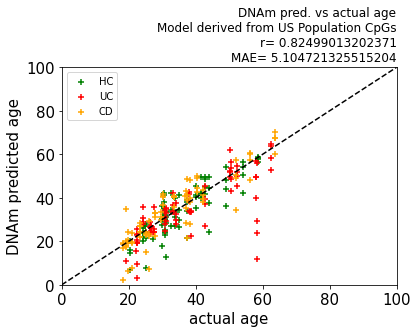

In [320]:
plt.scatter(age_vals[hc_indices], ibs_age_pred[hc_indices], label= "HC", marker= "+", color= "green")
plt.scatter(age_vals[uc_indices], ibs_age_pred[uc_indices], label= "UC", marker= "+", color= "red")
plt.scatter(age_vals[cd_indices], ibs_age_pred[cd_indices], label= "CD", marker= "+", color= "orange")

pop_model_ibs_file_name = os.path.join(FIGURES_DIR, "ibs_test_gen_2")
finalize_scatter_plot(age_vals, ibs_age_pred, "Model derived from US Population CpGs", pop_model_ibs_file_name)

In [321]:
d = {"pred_age": ibs_age_pred, "actual_age": age_vals}
d

{'pred_age': array([34.82413124, 31.24132353, 11.92072118, 23.92858311, 48.94060417,
        28.6137459 , 25.95125562, 44.66268543, 60.10002874, 41.15580066,
        58.87274885, 43.00628008, 64.52763005, 33.84726584, 43.72396794,
        37.87469897, 67.46055416, 49.81071886, 40.22288876, 24.20146436,
        62.00098666, 41.44430876, 32.9632004 , 36.4145565 , 23.47114726,
        25.79519322, 41.35196812, 42.41766446, 50.3079696 , 33.76380761,
         9.59427034, 21.99759187, 48.60485043, 23.71096746, 40.43031102,
        35.92306567, 34.74134176, 35.42069355, 34.34132797, 50.64676694,
        54.32782827, 26.92651933, 29.55064076, 44.41597194, 36.64028942,
        28.00600965, 40.77063089, 29.85374186, 52.50585748, 52.57605963,
        48.4982799 , 34.00241051, 41.97704438, 70.30340757, 48.13874943,
        26.18676832, 27.05879584, 42.27322256, 60.31171623, 57.30142411,
        41.81553961, 36.27100226, 30.56794292, 23.55200149, 40.74353879,
        24.27212409, 49.77490015, 29.11

In [322]:
ibs_results = pd.DataFrame(data= d)
ibs_results

,pred_age,actual_age
0,34.824131,19.1
1,31.241324,30.8
2,11.920721,58.4
3,23.928583,21.1
4,48.940604,40.3
...,...,...
235,36.907282,30.3
236,29.002576,26.5
237,20.937378,27.3
238,10.750014,19.1


In [323]:
ibs_results.to_csv("./ibs_results_gen_2.csv")

### Let's create a plot showing all disease and healthy samples

In [368]:
all_samples = []
all_predictions = []

healthy_indices = []
diseased_indices = []

# IBS
all_samples.extend(age_vals)
all_predictions.extend(ibs_age_pred)
healthy_indices.extend(hc_indices)
ibs_diseased_indices = []
for i in hc_indices:
    if i == True:
        ibs_diseased_indices.append(False)
    else:
        ibs_diseased_indices.append(True)
        
diseased_indices.extend(ibs_diseased_indices)
        
# HIV
all_samples.extend(y_HIV)
all_predictions.extend(age_pred_HIV_medium)
hiv_health_indices = []
hiv_dis_indices = []
for _ in range(len(y_HIV)):
    hiv_health_indices.append(False)
    hiv_dis_indices.append(True)
healthy_indices.extend(hiv_health_indices)
diseased_indices.extend(hiv_dis_indices)

# Werner
all_samples.extend(werner_ages)
all_predictions.extend(werner_age_pred)
werner_health_indices = []
werner_dis_indices = []
for _ in range(len(werner_ages)):
    werner_health_indices.append(False)
    werner_dis_indices.append(True)
healthy_indices.extend(werner_health_indices)
diseased_indices.extend(werner_dis_indices)

# MS
all_samples.extend(ms_ages)
all_predictions.extend(ms_age_pred)
healthy_indices.extend(healthy_ind)        
diseased_indices.extend(ms_ind)

# Down Syndrome
all_samples.extend(y_ds)
all_predictions.extend(medium_pop_cpgs_ds_age_pred)
diseased_indices.extend(ds_c1_ind)
healthy_indices.extend(ds_c0_ind)

# Arthritis
all_samples.extend(y_rheu)
all_predictions.extend(medium_pop_cpgs_arth_age_pred)
diseased_indices.extend(arth_c1_ind)
healthy_indices.extend(arth_c0_ind)

all_samples = np.array(all_samples)
all_predictions = np.array(all_predictions)

In [369]:
len(all_samples), len(all_predictions)

(1412, 1412)

In [370]:
len(healthy_indices), len(diseased_indices)

(1412, 1412)

In [375]:
num_normal_samples = 0
num_diseased_samples = 0
for is_healthy in healthy_indices:
    if is_healthy:
        num_normal_samples += 1
    else:
        num_diseased_samples += 1

In [377]:
num_normal_samples + num_diseased_samples

1412

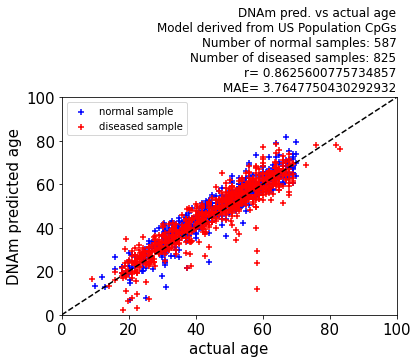

In [376]:
plt.scatter(all_samples[healthy_indices], all_predictions[healthy_indices], label= "normal sample", marker= "+", color= "blue")
plt.scatter(all_samples[diseased_indices], all_predictions[diseased_indices], label= "diseased sample", marker= "+", color= "red")

us_pop_all_datasets_filename = os.path.join(FIGURES_DIR, "us_pop_model_all_datasets")
all_samples_plot_title = f"Model derived from US Population CpGs\nNumber of normal samples: {num_normal_samples}\nNumber of diseased samples: {num_diseased_samples}"
finalize_scatter_plot(dis_ages, dis_park_age_pred, all_samples_plot_title, us_pop_all_datasets_filename)

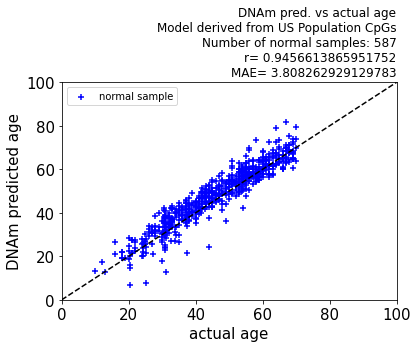

In [378]:
plt.scatter(all_samples[healthy_indices], all_predictions[healthy_indices], label= "normal sample", marker= "+", color= "blue")

us_pop_all_datasets_filename = os.path.join(FIGURES_DIR, "us_pop_model_all_datasets_normal_only")
all_samples_plot_title = f"Model derived from US Population CpGs\nNumber of normal samples: {num_normal_samples}"
finalize_scatter_plot(all_samples[healthy_indices], all_predictions[healthy_indices], all_samples_plot_title, us_pop_all_datasets_filename)

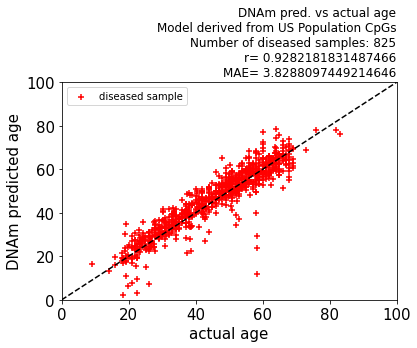

In [380]:
plt.scatter(all_samples[diseased_indices], all_predictions[diseased_indices], label= "diseased sample", marker= "+", color= "red")

us_pop_all_datasets_filename = os.path.join(FIGURES_DIR, "us_pop_model_all_datasets_diseased_only")
all_samples_plot_title = f"Model derived from US Population CpGs\nNumber of diseased samples: {num_diseased_samples}"
finalize_scatter_plot(all_samples[diseased_indices], all_predictions[diseased_indices], all_samples_plot_title, us_pop_all_datasets_filename)

### Let's show the statistics of the population that we plotted

In [383]:
all_residuals = all_predictions - all_samples
all_residuals

array([ 15.72413124,   0.44132353, -46.47927882, ...,   2.10231964,
         3.44741677,   2.70780923])

In [384]:
diseased_residuals = all_residuals[diseased_indices]
healthy_residuals = all_residuals[healthy_indices]

len(diseased_residuals), len(healthy_residuals)

(825, 587)

In [410]:
healthy_residuals_dict = {"normal_residuals": healthy_residuals}
diseased_residuals_dict = {"diseased_residuals": diseased_residuals}

healthy_resid_df = pd.DataFrame(data= healthy_residuals_dict)
diseased_residuals_df = pd.DataFrame(data= diseased_residuals_dict)

healthy_resid_df, diseased_residuals_df

(     normal_residuals
 0            0.441324
 1            1.651256
 2           10.455801
 3            0.372749
 4            0.474699
 ..                ...
 582         -1.685414
 583         -5.827176
 584          2.102320
 585          3.447417
 586          2.707809
 
 [587 rows x 1 columns],
      diseased_residuals
 0             15.724131
 1            -46.479279
 2              2.828583
 3              8.640604
 4              5.213746
 ..                  ...
 820            2.691446
 821           -1.228346
 822            7.255156
 823            8.246397
 824            0.676694
 
 [825 rows x 1 columns])

In [411]:
healthy_resid_df.to_csv("us_pop_all_healthy_resid")
diseased_residuals_df.to_csv("us_pop_all_diseased_resid")

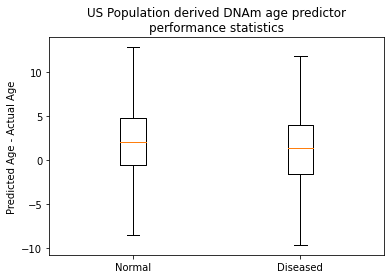

In [412]:
from matplotlib.patches import Polygon

data = [healthy_residuals, diseased_residuals]

plt.boxplot(data, 0, '', labels= ["Normal", "Diseased"])
plt.ylabel("Predicted Age - Actual Age")
plt.title("US Population derived DNAm age predictor\nperformance statistics")
plot_filename = "all_samples_boxplot"
plt.savefig(fname= f"{plot_filename}", bbox_inches= "tight", dpi= 600)
plt.show()

### Let's randomize the test age values and see what the accuracy looks like

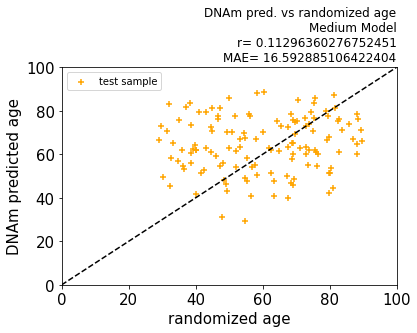

In [51]:
randomized_medium_age_test = randomize_ages(medium_age_test)

plt.scatter(randomized_medium_age_test, medium_X_test_predict, label= "test sample", marker= "+", color= "orange")
medium_rand_test_ages_file_name = os.path.join(FIGURES_DIR, "medium_model_test_randomized_test_ages")
finalize_random_scatter_plot(randomized_medium_age_test, medium_X_test_predict, "Medium Model", medium_rand_test_ages_file_name)

## Testing the Small Model on Medium Model's data

In [30]:
medium_X_small_test = medium_X[small_CpG_list]
medium_X_small_test = small_scaler.transform(medium_X_small_test)
small_prediction_on_medium_X = small_model.predict(medium_X_small_test)

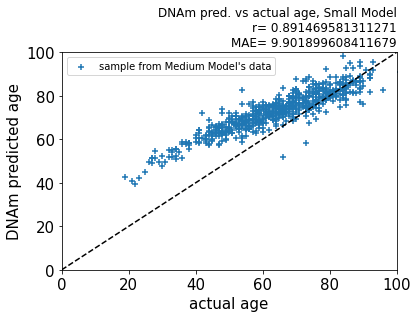

In [31]:
plt.scatter(medium_age, small_prediction_on_medium_X, marker= "+", label= "sample from Medium Model's data")
small_model_test_on_medium_X_file_name = os.path.join(FIGURES_DIR, "small_model_test_on_medium_X")
finalize_scatter_plot(medium_age, small_prediction_on_medium_X, "Small Model", small_model_test_on_medium_X_file_name)

## BRCA1 testing set

In [7]:
brca1_data = ["GSE57285"]

In [8]:
X_brca1, y_brca1 = process_data(brca1_data)

In [9]:
_, brca_stat = process_data(brca1_data, info= "brca1")

In [10]:
brca_c0_ind = [0 == code for code in brca_stat]
brca_c1_ind = [1 == code for code in brca_stat]
brca_c2_ind = [2 == code for code in brca_stat]

### testing the Small Model

In [36]:
X_brca1_small = X_brca1[small_CpG_list]

In [37]:
X_brca1_small.head(4)

ID_REF               cg04684516  cg06589885  cg09096950  cg06946880  \
GSE57285 GSM1378474    0.047600    0.955254    0.235923    0.929410   
         GSM1378475    0.033691    0.934630    0.253566    0.921924   
         GSM1378476    0.024014    0.938689    0.186758    0.916609   
         GSM1378477    0.028970    0.945728    0.178174    0.917129   

ID_REF               cg17885062  cg17380128  cg17889103  cg00128877  \
GSE57285 GSM1378474    0.030214    0.030739    0.033336    0.087729   
         GSM1378475    0.042918    0.026166    0.029789    0.084676   
         GSM1378476    0.033365    0.030268    0.037821    0.072796   
         GSM1378477    0.041831    0.035332    0.041304    0.088840   

ID_REF               cg09935228  cg14658362  ...  cg22284975  cg01876612  \
GSE57285 GSM1378474    0.920205    0.034483  ...    0.068880    0.047755   
         GSM1378475    0.904363    0.030121  ...    0.077235    0.042457   
         GSM1378476    0.912634    0.031294  ...    0.059521    0.063507   
         GSM1378477    0.892030    0.027358  ...    0.065480    0.059604   

ID_REF               cg13180809  cg07191600  cg20091107  cg20828084  \
GSE57285 GSM1378474    0.035347    0.020202    0.010545    0.823935   
         GSM1378475    0.036708    0.013662    0.015705    0.826969   
         GSM1378476    0.037339    0.012759    0.016225    0.872644   
         GSM1378477    0.038305    0.014002    0.016698    0.862540   

ID_REF               cg13906416  cg16302441  cg18441959  cg13985639  
GSE57285 GSM1378474    0.039125    0.496221    0.519189    0.714697  
         GSM1378475    0.064547    0.539281    0.327344    0.692692  
         GSM1378476    0.052771    0.453482    0.504939    0.702246  
         GSM1378477    0.044478    0.410921    0.472632    0.737059  

[4 rows x 23758 columns]

In [38]:
X_brca1_small = small_scaler.transform(X_brca1_small)

In [39]:
small_brca1_age = small_model.predict(X_brca1_small)

In [40]:
small_brca1_age = np.array(small_brca1_age)

In [41]:
del X_brca1_small, _,

In [87]:
y_brca1_arr = np.array(y_brca1)

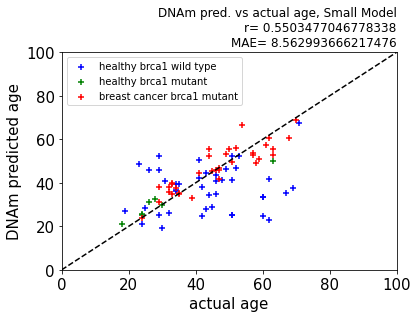

In [43]:
plt.scatter(y_brca1_arr[brca_c0_ind], small_brca1_age[brca_c0_ind], label= "healthy brca1 wild type", marker= "+", color= "blue")
plt.scatter(y_brca1_arr[brca_c1_ind], small_brca1_age[brca_c1_ind], color= "green", label= "healthy brca1 mutant", marker= "+")
plt.scatter(y_brca1_arr[brca_c2_ind], small_brca1_age[brca_c2_ind], color= "red", label= "breast cancer brca1 mutant", marker= "+")

small_brca1_file_name = os.path.join(FIGURES_DIR, "small_model_brca1_test")
finalize_scatter_plot(y_brca1_arr, small_brca1_age, "Small Model", small_brca1_file_name)

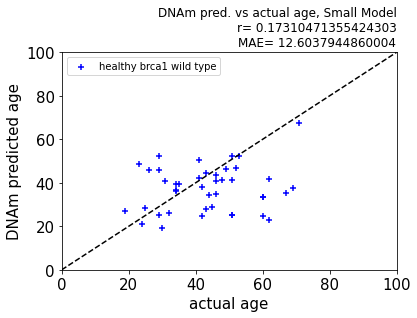

In [44]:
plt.scatter(y_brca1_arr[brca_c0_ind], small_brca1_age[brca_c0_ind], label= "healthy brca1 wild type", marker= "+", color= "blue")

small_brca1_healthy_wild_type_file_name = os.path.join(FIGURES_DIR, "small_model_brca1_healthy_wild_type_test")
finalize_scatter_plot(y_brca1_arr[brca_c0_ind], small_brca1_age[brca_c0_ind], "Small Model",
                      small_brca1_healthy_wild_type_file_name)

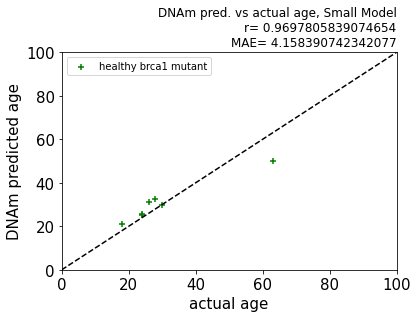

In [45]:
plt.scatter(y_brca1_arr[brca_c1_ind], small_brca1_age[brca_c1_ind], color= "green", label= "healthy brca1 mutant", marker= "+")

small_brca1_healthy_mutant_file_name = os.path.join(FIGURES_DIR, "small_model_brca1_healthy_mutant_test")
finalize_scatter_plot(y_brca1_arr[brca_c1_ind], small_brca1_age[brca_c1_ind], "Small Model",
                      small_brca1_healthy_mutant_file_name)

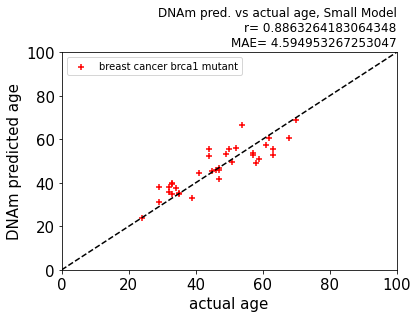

In [46]:
plt.scatter(y_brca1_arr[brca_c2_ind], small_brca1_age[brca_c2_ind], color= "red", label= "breast cancer brca1 mutant", marker= "+")
small_brca1_cancer_mutant_file_name = os.path.join(FIGURES_DIR, "small_model_brca1_cancer_mutant_test")
finalize_scatter_plot(y_brca1_arr[brca_c2_ind], small_brca1_age[brca_c2_ind], "Small Model",
                      small_brca1_cancer_mutant_file_name)

In [117]:
# X_brca1 is a 28k dataset so we can't test with Hannum 

## HIV

In [118]:
HIV_male_data = ["GSE53840"]

In [119]:
X_HIV, y_HIV = process_data(HIV_male_data)

In [120]:
X_HIV["age"] = y_HIV

In [121]:
# we need to filter for missing ages (they default to 0)
X_HIV = X_HIV[X_HIV["age"] != 0.0]

row_keep = [a != 0.0 for a in y_HIV]
y_HIV = np.array(y_HIV)[row_keep]

In [122]:
X_HIV.drop(labels= "age", axis= "columns", inplace= True)

In [123]:
X_HIV.head(4)

ID_REF               cg00000029  cg00000108  cg00000109  cg00000165  \
GSE53840 GSM1301871    0.424289    0.930399    0.830893    0.340161   
         GSM1301872    0.591058    0.917798    0.834512    0.366086   
         GSM1301873    0.545455    0.904169    0.800456    0.379825   
         GSM1301874    0.485343    0.928916    0.821711    0.295978   

ID_REF               cg00000236  cg00000289  cg00000292  cg00000321  \
GSE53840 GSM1301871    0.725072    0.600667    0.831663    0.408293   
         GSM1301872    0.742132    0.550339    0.805495    0.285659   
         GSM1301873    0.684540    0.563581    0.805165    0.309745   
         GSM1301874    0.619807    0.589676    0.789118    0.288863   

ID_REF               cg00000363  cg00000622  ...  cg27665767  cg27665769  \
GSE53840 GSM1301871    0.488906    0.034326  ...    0.388448    0.387542   
         GSM1301872    0.486490    0.026814  ...    0.479168    0.358882   
         GSM1301873    0.334252    0.028865  ...    0.449645    0.422811   
         GSM1301874    0.359756    0.023670  ...    0.365971    0.385711   

ID_REF               cg27665808  cg27665823  cg27665829  cg27665860  \
GSE53840 GSM1301871    0.699722    0.934399    0.864611    0.815491   
         GSM1301872    0.616102    0.929681    0.822570    0.845937   
         GSM1301873    0.587324    0.938189    0.811546    0.832136   
         GSM1301874    0.650956    0.943028    0.808709    0.837675   

ID_REF               cg27665925  cg27665985  cg27666046  cg27666123  
GSE53840 GSM1301871    0.061597    0.399162    0.512386    0.723583  
         GSM1301872    0.053814    0.260563    0.682825    0.774066  
         GSM1301873    0.047101    0.235056    0.761953    0.825112  
         GSM1301874    0.052208    0.228265    0.738161    0.800497  

[4 rows x 482421 columns]

### Testing the Small Model

In [54]:
X_HIV_small = X_HIV[small_CpG_list]

In [55]:
X_HIV_small = small_scaler.transform(X_HIV_small)

In [56]:
small_HIV_age_pred = small_model.predict(X_HIV_small)

In [57]:
small_HIV_age_pred = np.array(small_HIV_age_pred)

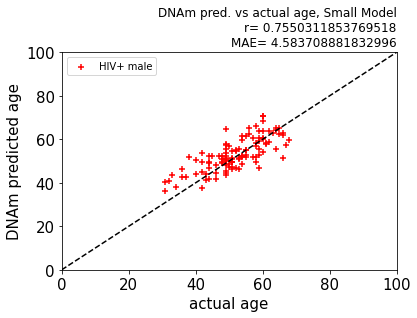

In [58]:
plt.scatter(y_HIV, small_HIV_age_pred, label= "HIV+ male", marker= "+", color= "red")
small_HIV_file_name = os.path.join(FIGURES_DIR, "small_model_HIV_test")
finalize_scatter_plot(y_HIV, small_HIV_age_pred, "Small Model", small_HIV_file_name)

### Testing the Medium Model

In [63]:
X_HIV_medium = X_HIV[medium_CpG_list]

In [64]:
X_HIV_medium = medium_scaler.transform(X_HIV_medium)

In [65]:
age_pred_HIV_medium = medium_model.predict(X_HIV_medium)

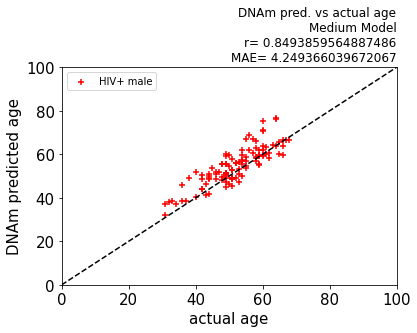

In [66]:
plt.scatter(y_HIV, age_pred_HIV_medium, label= "HIV+ male", marker= "+", color= "red")
medium_HIV_file_name = os.path.join(FIGURES_DIR, "medium_HIV_test")
finalize_scatter_plot(y_HIV, age_pred_HIV_medium, "Medium Model", medium_HIV_file_name)

In [70]:
hiv_pred_results_dict = {'actual age': y_HIV, 'predicted': age_pred_HIV_medium}
hiv_pred_results_dataframe = pd.DataFrame(data=hiv_pred_results_dict)
hiv_pred_results_dataframe.to_csv('medium_model_hiv_pred_results.csv')
hiv_pred_results_dataframe

,actual age,predicted
0,54.0,57.242831
1,61.0,60.234724
2,51.0,52.967935
3,49.0,49.920074
4,60.0,59.266362
...,...,...
106,51.0,48.686821
107,46.0,50.817406
108,31.0,32.129107
109,48.0,49.657418


## Rheumatoid arthritis

In [71]:
rheu_data = ["GSE42861"]

In [72]:
X_rheu, y_rheu = process_data(rheu_data)

In [73]:
_, rheu_stat = process_data(rheu_data, info= "arthritis")

In [74]:
arth_c0_ind = ["normal" == code for code in rheu_stat]
arth_c1_ind = ["rheumatoid arthritis" == code for code in rheu_stat]

In [75]:
del _

### Testing the Small Model

In [40]:
X_rheu_small = X_rheu[small_CpG_list]

In [41]:
X_rheu_small = small_scaler.transform(X_rheu_small)

NameError: name 'small_scaler' is not defined

In [ ]:
small_rheu_age_pred = small_model.predict(X_rheu_small)

In [ ]:
small_rheu_age_pred = np.array(small_rheu_age_pred)

In [ ]:
y_rheu = np.array(y_rheu)

In [ ]:
plt.scatter(y_rheu[arth_c0_ind], small_rheu_age_pred[arth_c0_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_rheu[arth_c1_ind], small_rheu_age_pred[arth_c1_ind], color= "red", label= "rheumatoid arthritis", marker= "+")
small_rheu_arthritis_file_name = os.path.join(FIGURES_DIR, "small_model_rheu_arthritis_test")
finalize_scatter_plot(y_rheu, small_rheu_age_pred, "Small Model", small_rheu_arthritis_file_name)

### Testing the Medium Model

In [76]:
X_rheu_medium = X_rheu[medium_CpG_list]

In [77]:
X_rheu_medium = medium_scaler.transform(X_rheu_medium)

In [78]:
medium_rheu_age_pred = medium_model.predict(X_rheu_medium)

In [79]:
y_rheu = np.array(y_rheu)

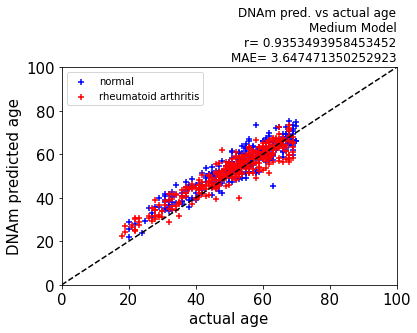

In [80]:
plt.scatter(y_rheu[arth_c0_ind], medium_rheu_age_pred[arth_c0_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_rheu[arth_c1_ind], medium_rheu_age_pred[arth_c1_ind], color= "red", label= "rheumatoid arthritis", marker= "+")
medium_rheu_arthritis_file_name = os.path.join(FIGURES_DIR, "medium_model_rheu_arthritis_test")
finalize_scatter_plot(y_rheu, medium_rheu_age_pred, "Medium Model", medium_rheu_arthritis_file_name)

In [81]:
arth_pred_results_dict = {'actual age': y_rheu, 'predicted': medium_rheu_age_pred}
arth_pred_results_dataframe = pd.DataFrame(data=arth_pred_results_dict)
arth_pred_results_dataframe.to_csv('medium_model_arthritis_pred_results.csv')
arth_pred_results_dataframe

,actual age,predicted
0,67.0,63.152766
1,49.0,49.993770
2,53.0,53.535677
3,62.0,62.836643
4,33.0,36.384784
...,...,...
684,63.0,59.890137
685,63.0,45.213765
686,46.0,49.917704
687,64.0,66.246889


## Crohn's disease

In [78]:
crohns_data = ["GSE32148"]

In [79]:
X_crohns, y_crohns = process_data(crohns_data)

In [80]:
# some samples are missing
X_crohns.shape

(48, 482421)

In [81]:
y_crohns[0]

49.0

In [82]:
_, crohns_stat = process_data(crohns_data, info= "crohns")

In [83]:
crohns_c0_ind = ["Crohn's" == code for code in crohns_stat]
crohns_c1_ind = ["normal" == code for code in crohns_stat]
crohns_c2_ind = ["ulcerative" == code for code in crohns_stat]

In [84]:
y_crohns_arr = np.array(y_crohns)

### Testing the Small Model

In [85]:
X_crohns_small = X_crohns[small_CpG_list]

In [86]:
X_crohns_small = small_scaler.transform(X_crohns_small)

In [87]:
small_crohns_age_pred = small_model.predict(X_crohns_small)

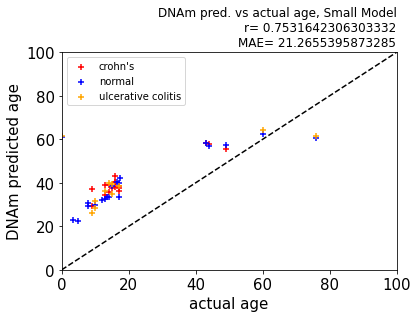

In [88]:
plt.scatter(y_crohns_arr[crohns_c0_ind], small_crohns_age_pred[crohns_c0_ind], color= "red", label= "crohn's", marker= "+")
plt.scatter(y_crohns_arr[crohns_c1_ind], small_crohns_age_pred[crohns_c1_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_crohns_arr[crohns_c2_ind], small_crohns_age_pred[crohns_c2_ind], color= "orange", label= "ulcerative colitis", marker= "+")
small_crohns_file_name = os.path.join(FIGURES_DIR, "small_model_crohns_test")
finalize_scatter_plot(y_crohns_arr, small_crohns_age_pred, "Small Model", small_crohns_file_name)

### Testing the Medium Model

In [89]:
X_crohns_medium = X_crohns[medium_CpG_list]

In [90]:
X_crohns_medium = medium_scaler.transform(X_crohns_medium)

In [91]:
medium_crohns_age_pred = medium_model.predict(X_crohns_medium)

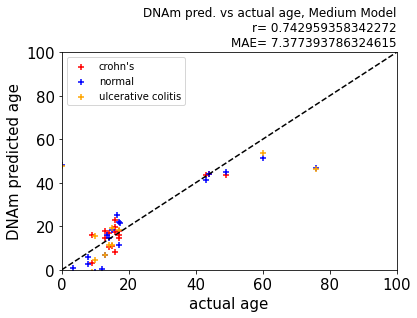

In [92]:
plt.scatter(y_crohns_arr[crohns_c0_ind], medium_crohns_age_pred[crohns_c0_ind], color= "red", label= "crohn's", marker= "+")
plt.scatter(y_crohns_arr[crohns_c1_ind], medium_crohns_age_pred[crohns_c1_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_crohns_arr[crohns_c2_ind], medium_crohns_age_pred[crohns_c2_ind], color= "orange", label= "ulcerative colitis", marker= "+")
medium_crohns_file_name = os.path.join(FIGURES_DIR, "medium_model_crohns_test")
finalize_scatter_plot(y_crohns_arr, medium_crohns_age_pred, "Medium Model", medium_crohns_file_name)

## Down Syndrome

In [82]:
down_syn_data = ["GSE52588"]

In [83]:
X_ds, y_ds = process_data(down_syn_data)

In [84]:
X_ds["age"] = y_ds

In [85]:
y_ds = np.array(y_ds)

In [86]:
_, ds_status = process_data(down_syn_data, info= "down syndrome")

In [87]:
ds_c0_ind = ["Down" == code for code in ds_status]
ds_c1_ind = ["healthy" == code for code in ds_status]

### Testing the Small Model

In [99]:
X_ds_small = X_ds[small_CpG_list]

In [100]:
X_ds_small = small_scaler.transform(X_ds_small)

In [101]:
small_ds_age_pred = small_model.predict(X_ds_small)

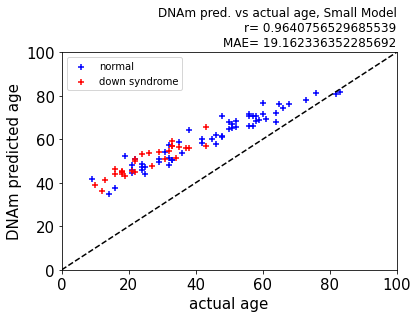

In [102]:
plt.scatter(y_ds[ds_c1_ind], small_ds_age_pred[ds_c1_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_ds[ds_c0_ind], small_ds_age_pred[ds_c0_ind], color= "red", label= "down syndrome", marker= "+")
small_ds_file_name = os.path.join(FIGURES_DIR, "small_model_down_syndrome_test")
finalize_scatter_plot(y_ds, small_ds_age_pred, "Small Model", small_ds_file_name)

### Testing the Medium Model

In [88]:
X_ds_medium = X_ds[medium_CpG_list]

In [89]:
X_ds_medium = medium_scaler.transform(X_ds_medium)

In [90]:
medium_ds_age_pred = medium_model.predict(X_ds_medium)

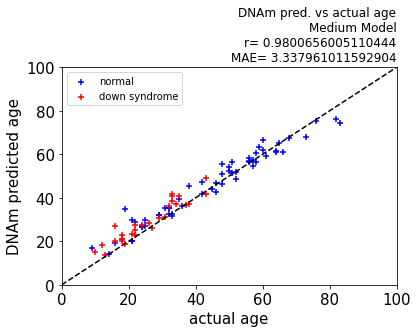

In [91]:
plt.scatter(y_ds[ds_c1_ind], medium_ds_age_pred[ds_c1_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_ds[ds_c0_ind], medium_ds_age_pred[ds_c0_ind], color= "red", label= "down syndrome", marker= "+")
medium_ds_file_name = os.path.join(FIGURES_DIR, "medium_model_test_down_syndrome")
finalize_scatter_plot(y_ds, medium_ds_age_pred, "Medium Model", medium_ds_file_name)

In [92]:
down_pred_results_dict = {'actual age': y_ds, 'predicted': medium_ds_age_pred}
down_pred_results_dataframe = pd.DataFrame(data=down_pred_results_dict)
down_pred_results_dataframe.to_csv('medium_model_down_pred_results.csv')
down_pred_results_dataframe

,actual age,predicted
0,18.0,20.833745
1,12.0,18.378182
2,13.0,13.881701
3,24.0,27.355678
4,33.0,40.763076
...,...,...
82,66.0,61.300543
83,60.0,66.753187
84,68.0,67.578054
85,48.0,46.249224


## PhenoAge model vs disease datasets

#### let's create the PhenoAge model using their provided CpG weights.

In [80]:
raw_pheno_age_model_data = pd.read_csv("pheno_age_cpg_data.csv")
raw_pheno_age_model_data.head(4)

,CpG,Chromosome,Map Info,Gene Symbol,Entrez ID,Weight,Univariate Age Correlation,Horvath Overlap,Hannum Overlap
0,Intercept,NaN,NaN,NaN,NaN,60.664000,NaN,NaN,NaN
1,cg15611364,3.0,25806427.0,OXSM,54995.0,63.124150,0.003807,No,No
2,cg17605084,12.0,53177758.0,HEM1,3071.0,-44.009393,-0.029169,No,No
3,cg26382071,17.0,6485627.0,TXNL5,84817.0,40.420854,0.002997,No,No


In [81]:
cpg_and_weight = raw_pheno_age_model_data.loc[:, ["CpG", "Weight"]]
cpg_and_weight

,CpG,Weight
0,Intercept,60.664000
1,cg15611364,63.124150
2,cg17605084,-44.009393
3,cg26382071,40.420854
4,cg12743894,36.788184
...,...,...
509,cg17861230,0.023738
510,cg08212685,0.012944
511,cg12373771,0.010527
512,cg00503840,0.002680


In [82]:
all_pheno_age_cpgs = cpg_and_weight.loc[:, "CpG"]
weights = cpg_and_weight.loc[:, "Weight"]

cpg_to_weight_tuple = zip(all_pheno_age_cpgs, weights)

cpg_to_weight_dict = dict(cpg_to_weight_tuple)
cpg_to_weight_dict

{'Intercept': 60.664,
 'cg15611364': 63.12415047,
 'cg17605084': -44.00939313,
 'cg26382071': 40.42085373,
 'cg12743894': 36.7881845,
 'cg19287114': -36.49384395,
 'cg12985418': -35.90008808,
 'cg19398783': 35.83308293,
 'cg15963417': -34.69842764,
 'cg27187881': -33.54555855,
 'cg09892203': -33.4823461,
 'cg00943950': 33.47697933,
 'cg18996776': 33.05057141,
 'cg16340918': 32.14665692,
 'cg23832061': -31.90246973,
 'cg22736354': 31.84219355,
 'cg04084157': 31.62165709,
 'cg07265300': 28.3980076,
 'cg02503970': 25.58514041,
 'cg11426590': -24.78579343,
 'cg23710218': 24.15870289,
 'cg02802055': -24.11715679,
 'cg13631913': 23.83805501,
 'cg06493994': 23.37207957,
 'cg24304712': 23.3003573,
 'cg01131735': -22.91466682,
 'cg24208206': 22.54068526,
 'cg01930621': -21.78792705,
 'cg19104072': -21.59866911,
 'cg07850604': 21.31021579,
 'cg27493997': -21.2007229,
 'cg14281160': 21.11147672,
 'cg12247247': -20.75342001,
 'cg08331960': -20.70742942,
 'cg17726022': 20.18800473,
 'cg19722847': -

In [85]:
def make_pheno_age_prediction(X_cpg):
    predictions = np.zeros(len(X_cpg))
    intercept_key_name = "Intercept"
    for cpg in all_pheno_age_cpgs:
        if cpg == intercept_key_name:
            continue
        given_cpg_values = np.array(X_cpg.loc[:, cpg])
        pheno_age_cpg_coeff = cpg_to_weight_dict[cpg]
        new_pheno_age_term = pheno_age_cpg_coeff * given_cpg_values
        predictions += new_pheno_age_term
        
    predictions += cpg_to_weight_dict[intercept_key_name]
    
    return predictions

#### Now that we have the PhenoAge model made, let's make some predictions

##### BRCA1

In [86]:
pheno_age_brca1_pred = make_pheno_age_prediction(X_brca1)
pheno_age_brca1_pred

array([49.96033134, 39.39361172, 32.33531571, 31.75829281, 34.65465271,
       60.1678872 , 44.67446397, 28.91259359, 27.88499394, 41.01630162,
       38.39963121,  7.23888598, 42.21140788, 36.67856365, 54.85162224,
       35.84822396, 28.55876234,  6.59293625, 20.6513421 , 49.29404556,
       19.06764423, 33.1594632 , 64.87671984, 20.38425082, 34.84063842,
       26.05872856, 34.26531668, 33.80031682, 32.88408774,  9.38898395,
       17.38026367, 45.78823401, 31.65010618, 40.37225965, 46.04749316,
       24.70008581, 43.68552846, 39.58247758, 49.62630822, 27.79634238,
        2.70972908, 20.23120206, 27.25697474, 45.19467746, -3.75032402,
       18.8970337 , 50.35748328, 15.63045626, 38.14265341, 57.12648069,
       11.1529102 , 12.83559606, 12.71308887, 38.35033763, 45.49291149,
       28.42556498, 38.15259414, 27.64471688, 13.12237676, 35.9677795 ,
       13.28322481, 29.09975272, 43.24838012, 27.72809598, 19.53279989,
       16.86672686, 26.57574413, 44.27982955, 18.7800864 , 11.20

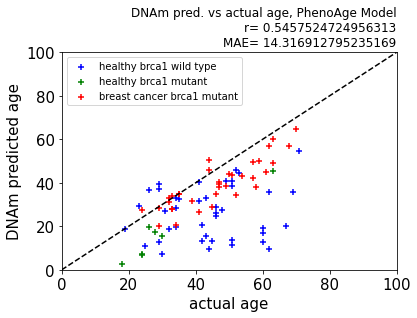

In [92]:
plt.scatter(y_brca1_arr[brca_c0_ind], pheno_age_brca1_pred[brca_c0_ind], label= "healthy brca1 wild type", marker= "+", color= "blue")
plt.scatter(y_brca1_arr[brca_c1_ind], pheno_age_brca1_pred[brca_c1_ind], color= "green", label= "healthy brca1 mutant", marker= "+")
plt.scatter(y_brca1_arr[brca_c2_ind], pheno_age_brca1_pred[brca_c2_ind], color= "red", label= "breast cancer brca1 mutant", marker= "+")

pheno_age_brca1_file_name = os.path.join(FIGURES_DIR, "pheno_age_on_brca1")
finalize_scatter_plot(y_brca1_arr, pheno_age_brca1_pred, "PhenoAge Model", pheno_age_brca1_file_name)

## Predicting US population from birth year

In [186]:
us_population_per_year = pd.read_csv("colin-us-population.csv")
us_population_per_year

,year,population
0,1910,92228531
1,1911,93607835
2,1912,94987138
3,1913,96366442
4,1914,97745746
...,...,...
106,2016,322367784
107,2017,324638158
108,2018,326908532
109,2019,329178907


In [187]:
us_population_per_year["factor_reduced_population"] = us_population_per_year["population"] / 100_000_000
us_population_per_year

,year,population,factor_reduced_population
0,1910,92228531,0.922285
1,1911,93607835,0.936078
2,1912,94987138,0.949871
3,1913,96366442,0.963664
4,1914,97745746,0.977457
...,...,...,...
106,2016,322367784,3.223678
107,2017,324638158,3.246382
108,2018,326908532,3.269085
109,2019,329178907,3.291789


In [188]:
year_to_us_population_tuple = zip(us_population_per_year.loc[:, "year"], us_population_per_year.loc[:, "factor_reduced_population"])
year_to_us_population_dict = dict(year_to_us_population_tuple)
year_to_us_population_dict

{1910: 0.92228531,
 1911: 0.93607835,
 1912: 0.94987138,
 1913: 0.96366442,
 1914: 0.97745746,
 1915: 0.9912505,
 1916: 1.00504353,
 1917: 1.01883657,
 1918: 1.03262961,
 1919: 1.04642264,
 1920: 1.06021568,
 1921: 1.07739677,
 1922: 1.09457786,
 1923: 1.11175896,
 1924: 1.12894005,
 1925: 1.14612114,
 1926: 1.16330223,
 1927: 1.18048332,
 1928: 1.19766442,
 1929: 1.21484551,
 1930: 1.2320266,
 1931: 1.24098907,
 1932: 1.24995154,
 1933: 1.25891401,
 1934: 1.26787648,
 1935: 1.27683895,
 1936: 1.28580141,
 1937: 1.29476388,
 1938: 1.30372635,
 1939: 1.31268882,
 1940: 1.32165129,
 1941: 1.34081196,
 1942: 1.35997263,
 1943: 1.3791333,
 1944: 1.39829397,
 1945: 1.41745464,
 1946: 1.4366153,
 1947: 1.45577597,
 1948: 1.47493664,
 1949: 1.49409731,
 1950: 1.51325798,
 1951: 1.54125536,
 1952: 1.56925273,
 1953: 1.59725011,
 1954: 1.62524749,
 1955: 1.65324487,
 1956: 1.68124224,
 1957: 1.70923962,
 1958: 1.737237,
 1959: 1.76523437,
 1960: 1.79323175,
 1961: 1.8171205,
 1962: 1.84100925,


In [189]:
def get_us_population_from_birth_year(y_age, year_published):
    population_from_birth_years = np.zeros(len(y_age))
    
    index_counter = 0
    for age in y_age:
        birth_year = year_published - round(age)
        us_population = year_to_us_population_dict[birth_year]
        population_from_birth_years[index_counter] = us_population
        index_counter += 1
        
    return population_from_birth_years

In [190]:
medium_data = ["GSE40279"]

In [191]:
medium_X, medium_age = process_data(medium_data)

In [192]:
# we need to filter the CpGs to a set that is compatible with other datasets (for now, just down syndrome)
medium_X = medium_X[medium_CpG_list]
len(medium_X.columns)

438866

In [193]:
gse40279_publish_year = 2012
medium_us_population_at_birth = get_us_population_from_birth_year(medium_age, gse40279_publish_year)
medium_us_population_at_birth

array([1.41745464, 1.11175896, 1.4366153 , 1.47493664, 1.51325798,
       1.14612114, 1.31268882, 1.29476388, 1.31268882, 1.21484551,
       1.2320266 , 1.88878675, 1.27683895, 1.737237  , 1.49409731,
       1.34081196, 1.39829397, 1.24995154, 1.06021568, 1.56925273,
       1.25891401, 1.39829397, 1.04642264, 1.19766442, 1.30372635,
       1.30372635, 1.28580141, 1.68124224, 1.32165129, 1.29476388,
       1.25891401, 1.31268882, 1.2320266 , 1.30372635, 1.25891401,
       1.737237  , 0.93607835, 1.25891401, 1.19766442, 1.18048332,
       1.14612114, 1.30372635, 1.27683895, 1.31268882, 1.14612114,
       1.18048332, 1.12894005, 1.4366153 , 1.26787648, 1.76523437,
       1.28580141, 1.41745464, 1.31268882, 1.737237  , 1.31268882,
       1.00504353, 1.65324487, 1.28580141, 1.91267551, 1.737237  ,
       1.31268882, 1.19766442, 1.51325798, 1.11175896, 1.39829397,
       1.51325798, 1.25891401, 1.32165129, 1.3791333 , 1.70923962,
       1.31268882, 1.25891401, 1.32165129, 1.11175896, 1.25891

In [194]:
medium_scaler = StandardScaler()

In [195]:
medium_X_train, medium_X_test, medium_us_population_at_birth_train, medium_us_population_at_birth_test = train_test_split(medium_X, medium_us_population_at_birth, test_size= 0.20)

In [196]:
medium_X_train = medium_scaler.fit_transform(medium_X_train)
medium_X_test = medium_scaler.transform(medium_X_test)

In [197]:
len(medium_X_test)

132

In [198]:
# For the reader's sake, we provide the hyperparameters determined by the following two lines.
# medium_model = model.ElasticNetCV(l1_ratio= [0.5, 0.7, 0.85, 0.9, 0.95, 0.97, 0.99], selection= "random")
# medium_model.fit(medium_X_train, medium_us_population_at_birth_train)

# alpha= 0.06470723076032536
# l1_ratio= 0.2


medium_model = model.ElasticNet(alpha= 0.06470723076032536, l1_ratio= 0.2)
medium_model.fit(medium_X_train, medium_us_population_at_birth_train)

ElasticNet(alpha=0.06470723076032536, l1_ratio=0.2)

In [199]:
def get_number_of_non_zero_coef(model):
    all_coef = model.coef_
    num_non_zero_coef = 0
    for c in all_coef:
        if c != 0:
            num_non_zero_coef += 1
    return num_non_zero_coef

In [200]:
def get_number_of_sizeable_coef(model):
    all_coef = model.coef_
    num_sizeable_coef = 0
    for c in all_coef:
        if abs(c) > 0.1:
            num_sizeable_coef += 1
    return num_sizeable_coef

In [201]:
get_number_of_non_zero_coef(medium_model)

139

In [202]:
get_number_of_sizeable_coef(medium_model)

0

In [203]:
len(medium_model.coef_)

438866

In [204]:
medium_X_test_predict = medium_model.predict(medium_X_test)
medium_X_test_predict

array([1.75663482, 1.93929187, 1.31209622, 1.29786446, 1.22133998,
       1.65805895, 1.70189467, 1.41587521, 1.74251601, 1.44513922,
       1.80862749, 1.67574898, 1.6424495 , 1.35946647, 1.41984463,
       1.3217651 , 1.70508477, 1.54540289, 2.03703043, 1.23474801,
       1.12685382, 1.53344107, 1.7369241 , 2.19726236, 1.73232499,
       1.53902146, 1.09703841, 1.42641606, 1.80139686, 1.82675237,
       1.43011322, 1.70177086, 1.67180418, 1.28004945, 1.53860367,
       1.28681364, 1.56051354, 1.09605088, 1.08850751, 1.47173283,
       1.39099919, 1.80707787, 1.3271654 , 1.6411759 , 1.69706617,
       2.25878412, 1.36030774, 1.32070296, 1.21090613, 1.33080925,
       1.44630795, 1.69309747, 1.54668324, 1.42951683, 1.81401581,
       1.48312851, 1.41278238, 1.29024847, 1.26904163, 1.49295451,
       1.37104173, 1.09535271, 1.40960906, 1.79194616, 1.23797135,
       1.52911153, 1.29775053, 1.48520356, 2.30474949, 1.49088492,
       1.29864447, 1.11217527, 1.43707741, 1.22084678, 1.77162

In [205]:
def finalize_scatter_plot_for_us_population(x, y, model_name, file_name, num_cpgs):
    r = stats.pearsonr(x, y)[0]
    mae_val = mae(x, y)
    
    title_config = {'fontsize': 10,
                    'fontweight' : 10,
                    'verticalalignment': 'baseline',
                    'horizontalalignment': "right"}

    plt.title(f"DNAm pred. US population at birth vs actual US population at birth {model_name}\nNumber of non-zero CpG weights: {num_cpgs}\nr= {r}\nMAE= {mae_val} (in hundred-millions)", fontdict= title_config, loc= "right")
    
    axis_buffer = 0.3
    
    max_x = max(x)
    max_y = max(y)
    axis_limit = max(max_x, max_y) + axis_buffer
    
    accuracy_line = [0, axis_limit]
    
    min_x = min(x)
    min_y = min(y)
    axis_floor = min(min_x, min_y) - axis_buffer
    
    plt.xlim(axis_floor, axis_limit)
    plt.ylim(axis_floor, axis_limit)
    
    plt.plot(accuracy_line, accuracy_line, ls= "--", color= "black")
    plt.xlabel("actual US population\nat birth (in hundred-millions)", fontsize= 9)
    plt.ylabel("DNAm predicted US population\nat birth (in hundred-millions)", fontsize= 9)
    
    plt.legend()
    plt.xticks(fontsize= 10)
    plt.yticks(fontsize= 10)
    plt.savefig(fname= f"{file_name}", bbox_inches= "tight", dpi= 600)
    plt.show()

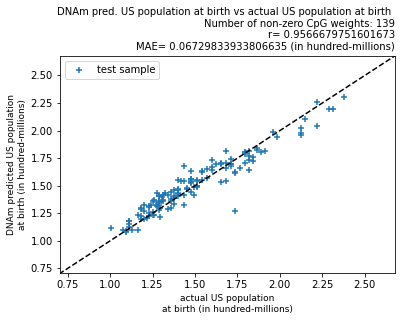

In [206]:
num_non_zero_cpgs = get_number_of_non_zero_coef(medium_model)
plt.scatter(medium_us_population_at_birth_test, medium_X_test_predict, label= "test sample", marker= "+")
us_population_file_name = os.path.join(FIGURES_DIR, "us_population_on_GSE40279_factor_reduced")
finalize_scatter_plot_for_us_population(
    medium_us_population_at_birth_test, 
    medium_X_test_predict, 
    "", 
    us_population_file_name,
    num_non_zero_cpgs
)

In [207]:
us_pop_cpgs_indices = set(get_non_zero_cpgs_indices(medium_model))

## Let's predict global warming from birth year

In [50]:
global_temp_per_year = pd.read_csv("global-temperature-over-time.txt", sep="\s+")
global_temp_per_year

,Year,No_Smoothing,Lowess(5)
0,1880,-0.17,-0.10
1,1881,-0.09,-0.13
2,1882,-0.11,-0.17
3,1883,-0.18,-0.20
4,1884,-0.28,-0.24
...,...,...,...
138,2018,0.85,0.93
139,2019,0.98,0.93
140,2020,1.02,0.92
141,2021,0.85,0.92


In [51]:
year_to_global_temp_tuple = zip(global_temp_per_year.loc[:, "Year"], global_temp_per_year.loc[:, "Lowess(5)"])
year_to_global_temp_dict = dict(year_to_global_temp_tuple)
year_to_global_temp_dict

{1880: -0.1,
 1881: -0.13,
 1882: -0.17,
 1883: -0.2,
 1884: -0.24,
 1885: -0.26,
 1886: -0.27,
 1887: -0.27,
 1888: -0.26,
 1889: -0.26,
 1890: -0.25,
 1891: -0.26,
 1892: -0.26,
 1893: -0.26,
 1894: -0.24,
 1895: -0.22,
 1896: -0.2,
 1897: -0.18,
 1898: -0.16,
 1899: -0.17,
 1900: -0.19,
 1901: -0.23,
 1902: -0.25,
 1903: -0.28,
 1904: -0.31,
 1905: -0.34,
 1906: -0.36,
 1907: -0.37,
 1908: -0.39,
 1909: -0.41,
 1910: -0.41,
 1911: -0.39,
 1912: -0.35,
 1913: -0.32,
 1914: -0.31,
 1915: -0.3,
 1916: -0.29,
 1917: -0.29,
 1918: -0.3,
 1919: -0.29,
 1920: -0.28,
 1921: -0.26,
 1922: -0.25,
 1923: -0.24,
 1924: -0.23,
 1925: -0.22,
 1926: -0.22,
 1927: -0.21,
 1928: -0.2,
 1929: -0.19,
 1930: -0.19,
 1931: -0.18,
 1932: -0.17,
 1933: -0.16,
 1934: -0.15,
 1935: -0.13,
 1936: -0.1,
 1937: -0.06,
 1938: -0.01,
 1939: 0.04,
 1940: 0.07,
 1941: 0.09,
 1942: 0.11,
 1943: 0.1,
 1944: 0.08,
 1945: 0.04,
 1946: 0.01,
 1947: -0.03,
 1948: -0.07,
 1949: -0.08,
 1950: -0.07,
 1951: -0.07,
 1952: -

In [52]:
def get_global_temp_from_birth_year(y_age, year_published):
    global_temp_from_birth_years = np.zeros(len(y_age))
    
    index_counter = 0
    for age in y_age:
        birth_year = year_published - round(age)
        global_temp = year_to_global_temp_dict[birth_year]
        global_temp_from_birth_years[index_counter] = global_temp
        index_counter += 1
        
    return global_temp_from_birth_years

In [53]:
medium_data = ["GSE40279"]

In [54]:
medium_X, medium_age = process_data(medium_data)

In [55]:
# we need to filter the CpGs to a set that is compatible with other datasets (for now, just down syndrome)
medium_X = medium_X[medium_CpG_list]
len(medium_X.columns)

438866

In [56]:
gse40279_publish_year = 2012
medium_global_temp_at_birth = get_global_temp_from_birth_year(medium_age, gse40279_publish_year)
medium_global_temp_at_birth = medium_global_temp_at_birth
medium_global_temp_at_birth

array([ 0.04, -0.24,  0.01, -0.07, -0.07, -0.22,  0.04, -0.06,  0.04,
       -0.19, -0.19, -0.04, -0.13, -0.01, -0.08,  0.09,  0.08, -0.17,
       -0.28, -0.07, -0.16,  0.08, -0.29, -0.2 , -0.01, -0.01, -0.1 ,
       -0.05,  0.07, -0.06, -0.16,  0.04, -0.19, -0.01, -0.16, -0.01,
       -0.39, -0.16, -0.2 , -0.21, -0.22, -0.01, -0.13,  0.04, -0.22,
       -0.21, -0.23,  0.01, -0.15,  0.01, -0.1 ,  0.04,  0.04, -0.01,
        0.04, -0.29, -0.06, -0.1 , -0.05, -0.01,  0.04, -0.2 , -0.07,
       -0.24,  0.08, -0.07, -0.16,  0.07,  0.1 , -0.04,  0.04, -0.16,
        0.07, -0.24, -0.16, -0.21,  0.08, -0.24,  0.04, -0.08, -0.15,
       -0.03, -0.03, -0.24, -0.21,  0.01, -0.1 , -0.01, -0.2 ,  0.09,
       -0.03,  0.1 , -0.08,  0.01, -0.21, -0.1 , -0.2 , -0.07,  0.11,
       -0.03,  0.08, -0.2 , -0.06,  0.01, -0.08,  0.1 , -0.15, -0.15,
        0.03, -0.03,  0.01, -0.07, -0.07, -0.06,  0.08, -0.01, -0.07,
       -0.1 , -0.01, -0.07, -0.04, -0.05, -0.07, -0.08, -0.17, -0.07,
        0.09,  0.04,

In [57]:
medium_scaler = StandardScaler()

In [58]:
medium_X_train, medium_X_test, medium_global_temp_at_birth_train, medium_global_temp_at_birth_test = train_test_split(medium_X, medium_global_temp_at_birth, test_size= 0.20)

In [59]:
medium_X_train = medium_scaler.fit_transform(medium_X_train)
medium_X_test = medium_scaler.transform(medium_X_test)

In [60]:
len(medium_X_test)

132

In [61]:
# For the reader's sake, we provide the hyperparameters determined by the following two lines.
# medium_model = model.ElasticNetCV(l1_ratio= [0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99], selection= "random")
# medium_model.fit(medium_X_train, medium_global_temp_at_birth_train)

# alpha= 0.18615062975221766
# l1_ratio= 0.05

medium_model = model.ElasticNet(l1_ratio=0.05, alpha= 0.18615062975221766)
medium_model.fit(medium_X_train, medium_global_temp_at_birth_train)

ElasticNet(alpha=0.18615062975221766, l1_ratio=0.05)

In [62]:
def get_number_of_non_zero_coef(model):
    all_coef = model.coef_
    num_non_zero_coef = 0
    for c in all_coef:
        if c != 0:
            num_non_zero_coef += 1
    return num_non_zero_coef

In [63]:
def get_number_of_sizeable_coef(model):
    all_coef = model.coef_
    num_sizeable_coef = 0
    for c in all_coef:
        if abs(c) > 0.1:
            num_sizeable_coef += 1
    return num_sizeable_coef

In [64]:
get_number_of_non_zero_coef(medium_model)

185

In [65]:
get_number_of_sizeable_coef(medium_model)

0

In [66]:
len(medium_model.coef_)

438866

In [67]:
medium_X_test_predict = medium_model.predict(medium_X_test)
medium_X_test_predict

array([-0.04414158, -0.00678046,  0.05643461, -0.00105624, -0.00805781,
       -0.02171823, -0.08292785, -0.01259624,  0.00888619, -0.03564075,
       -0.04395725,  0.00200066,  0.01184639, -0.0743621 , -0.0877041 ,
       -0.0661289 , -0.03848416, -0.01991332, -0.11088598, -0.112019  ,
       -0.1018406 , -0.00935928, -0.01679992, -0.02594182, -0.0521628 ,
       -0.04127337, -0.06001357, -0.00838281, -0.05989272,  0.04463702,
       -0.00234619, -0.0435369 , -0.06806576, -0.06213941, -0.02165798,
       -0.06558182, -0.01013527, -0.09780779, -0.03401167, -0.02133992,
       -0.0026778 , -0.13912023, -0.00903578, -0.09863961, -0.05938271,
       -0.00983797, -0.20478844, -0.03023703, -0.05835991, -0.06746671,
       -0.0300906 , -0.04185669, -0.1323838 ,  0.00499022, -0.0616979 ,
       -0.0934664 , -0.04232547, -0.0688947 ,  0.06400399,  0.07562468,
       -0.13942961, -0.20193756,  0.00447016, -0.10372594, -0.08107007,
       -0.00709925, -0.08655666, -0.06885219, -0.08016307, -0.12

In [68]:
def finalize_scatter_plot_for_global_temp(x, y, model_name, file_name):    
    
    r = stats.pearsonr(x, y)[0]
    mae_val = mae(x, y)
    
    title_config = {'fontsize': 10,
                    'fontweight' : 10,
                    'verticalalignment': 'baseline',
                    'horizontalalignment': "right"}

    plt.title(f"DNAm pred. global temp. at birth vs actual global temp. at birth {model_name}\nr= {r}\nMAE= {mae_val}", fontdict= title_config, loc= "right")
    
    axis_buffer = 0.1
    
    max_x = max(abs(x))
    max_y = max(abs(y))
    axis_limit = max(max_x, max_y) + axis_buffer
    
    accuracy_line = [-axis_limit, axis_limit]
    
    min_x = min(x)
    min_y = min(y)
    axis_floor = min(min_x, min_y) - axis_buffer
    
    plt.xlim(axis_floor, axis_limit)
    plt.ylim(axis_floor, axis_limit)
    
    plt.plot(accuracy_line, accuracy_line, ls= "--", color= "black")
    plt.xlabel("actual global temp. at birth", fontsize= 9)
    plt.ylabel("DNAm predicted global temp. at birth", fontsize= 9)
    
    plt.legend()
    plt.xticks(fontsize= 10)
    plt.yticks(fontsize= 10)
    plt.savefig(fname= f"{file_name}", bbox_inches= "tight", dpi= 600)
    plt.show()

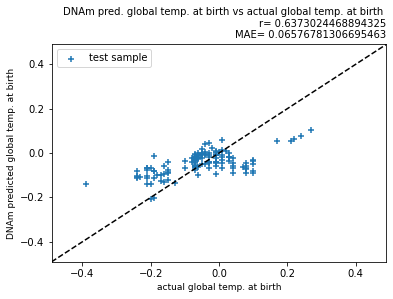

In [69]:
plt.scatter(medium_global_temp_at_birth_test, medium_X_test_predict, label= "test sample", marker= "+")
global_temp_file_name = os.path.join(FIGURES_DIR, "global_temp_on_GSE40279")
finalize_scatter_plot_for_global_temp(medium_global_temp_at_birth_test, medium_X_test_predict, "", global_temp_file_name)

In [71]:
global_temp_cpgs = set(get_non_zero_cpgs_indices(medium_model))

### Now to use these US population CpGs as a pre-filter for the age model

In [208]:
# filtered_cpgs = global_temp_cpgs.intersection(us_pop_cpgs_indices)
filtered_cpgs = us_pop_cpgs_indices

In [31]:
def get_non_zero_cpgs_indices(model):
    non_zero_indices = np.array([])
    coef_index = 0
    for coef in model.coef_:
        if coef != 0:
            non_zero_indices = np.append(non_zero_indices, coef_index)
            
        coef_index += 1
        
    return non_zero_indices

In [210]:
# global_temp_model_non_zero_cpg_indices = get_non_zero_cpgs_indices(medium_model)
# len(global_temp_model_non_zero_cpg_indices)

len(filtered_cpgs)

139

#### now let us select only these CpGs from our array to feed into a population model

In [211]:
medium_data = ["GSE40279"]

In [212]:
medium_X, medium_age = process_data(medium_data)

In [213]:
medium_X = medium_X[medium_CpG_list]
len(medium_X.columns)

438866

In [214]:
filtered_cpgs_ints = []
for cpg in filtered_cpgs:
    filtered_cpgs_ints.append(int(cpg))
len(filtered_cpgs_ints)

139

In [215]:
medium_X_global_temp_cpgs = medium_X.iloc[:, filtered_cpgs_ints]
len(medium_X_global_temp_cpgs.columns)

139

#### and rebuild the model as normal

In [216]:
medium_global_temp_cpgs_scaler = StandardScaler()

In [217]:
medium_X_global_temp_cpgs_train, medium_X_global_temp_cpgs_test, medium_age_global_temp_cpgs_train, medium_age_global_temp_cpgs_test = train_test_split(medium_X_global_temp_cpgs, medium_age, test_size= 0.20)

In [218]:
medium_X_global_temp_cpgs_train = medium_global_temp_cpgs_scaler.fit_transform(medium_X_global_temp_cpgs_train)
medium_X_global_temp_cpgs_test = medium_global_temp_cpgs_scaler.transform(medium_X_global_temp_cpgs_test)

In [219]:
medium_model_global_temp_cpgs = model.ElasticNetCV(
    l1_ratio= [0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99], 
    selection= "random"
)
medium_model_global_temp_cpgs.fit(medium_X_global_temp_cpgs_train, medium_age_global_temp_cpgs_train)

ElasticNetCV(l1_ratio=[0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99],
             selection='random')

In [220]:
medium_model_global_temp_cpgs.alpha_

0.45285355757347306

In [221]:
medium_model_global_temp_cpgs.l1_ratio_

0.05

In [222]:
get_number_of_non_zero_coef(medium_model_global_temp_cpgs)

135

In [223]:
medium_X_global_temp_cpgs_test_predict = medium_model_global_temp_cpgs.predict(medium_X_global_temp_cpgs_test)

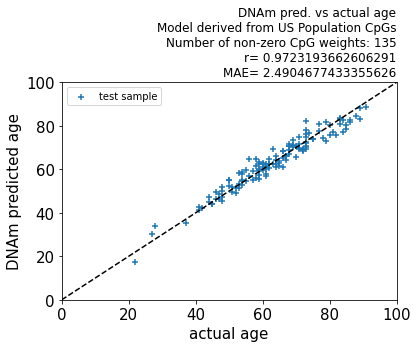

In [224]:
plt.scatter(medium_age_global_temp_cpgs_test, medium_X_global_temp_cpgs_test_predict, label= "test sample", marker= "+")
medium_global_temp_cpgs_file_name = os.path.join(FIGURES_DIR, "medium_model_us_pop_filtered")
non_zero_cpg_weights = get_number_of_non_zero_coef(medium_model_global_temp_cpgs)
finalize_scatter_plot(
    medium_age_global_temp_cpgs_test,
    medium_X_global_temp_cpgs_test_predict,
    f"Model derived from US Population CpGs\nNumber of non-zero CpG weights: {non_zero_cpg_weights}", 
    medium_global_temp_cpgs_file_name
)

### now let's make a prediction on the down syndrome set

In [225]:
down_syn_data = ["GSE52588"]

In [226]:
X_ds, y_ds = process_data(down_syn_data)

In [227]:
X_ds = X_ds[medium_CpG_list]
len(medium_X.columns)

438866

In [228]:
X_ds = X_ds.iloc[:, filtered_cpgs_ints]
len(X_ds.columns)

139

In [229]:
_, ds_status = process_data(down_syn_data, info= "down syndrome")

In [230]:
ds_c0_ind = ["Down" == code for code in ds_status]
ds_c1_ind = ["healthy" == code for code in ds_status]

In [231]:
X_ds = medium_global_temp_cpgs_scaler.transform(X_ds)

In [232]:
medium_pop_cpgs_ds_age_pred = medium_model_global_temp_cpgs.predict(X_ds)

In [233]:
y_ds = np.array(y_ds)

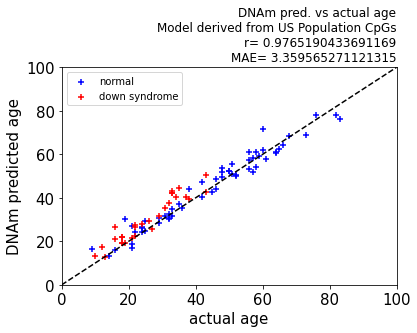

In [234]:
del X_ds

plt.scatter(y_ds[ds_c1_ind], medium_pop_cpgs_ds_age_pred[ds_c1_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_ds[ds_c0_ind], medium_pop_cpgs_ds_age_pred[ds_c0_ind], color= "red", label= "down syndrome", marker= "+")
medium_pop_cpgs_ds_file_name = os.path.join(FIGURES_DIR, "medium_model_test_down_syndrome_us_pop_cpgs")
finalize_scatter_plot(
    y_ds, 
    medium_pop_cpgs_ds_age_pred, 
    "Model derived from US Population CpGs", 
    medium_pop_cpgs_ds_file_name
)

In [235]:
d = {"pred_age": medium_pop_cpgs_ds_age_pred, "actual_age": y_ds}
d

{'pred_age': array([19.18845646, 17.22310509, 12.71551252, 28.14213134, 42.41481149,
        35.22441883, 19.28500735, 31.56564389, 26.72915652, 39.34605924,
        40.32063552, 40.2618914 , 13.25438105, 42.01586935, 44.34423202,
        22.18988188, 26.78044645, 19.2488361 , 25.52740295, 42.89585215,
        43.02487873, 27.69906273, 22.0178987 , 21.39274849, 37.52981659,
        29.44103496, 50.63687945, 20.86588131, 22.57162625, 27.21048885,
        24.17357467, 16.47348022, 18.78780839, 47.31916404, 26.8105612 ,
        29.51862033, 24.47422586, 34.71430492, 50.62548177, 30.8348197 ,
        44.09311534, 30.30923058, 35.12424   , 31.78231655, 15.93079211,
        17.05347924, 26.18865381, 28.62866182, 52.04842056, 50.05428117,
        32.5834439 , 24.58171759, 30.22133211, 37.0401959 , 31.5904435 ,
        44.0443665 , 13.3958466 , 30.92888192, 52.28577548, 51.12448374,
        40.32405102, 58.10105408, 62.58809069, 61.06959654, 53.81285655,
        55.41219391, 60.80213067, 76.16

In [236]:
ds_results = pd.DataFrame(data= d)
ds_results

,pred_age,actual_age
0,19.188456,18.0
1,17.223105,12.0
2,12.715513,13.0
3,28.142131,24.0
4,42.414811,33.0
...,...,...
82,64.233148,66.0
83,71.809476,60.0
84,68.219828,68.0
85,49.663046,48.0


In [237]:
ds_results.to_csv("./down_syndrome_results_gen_2.csv")

### now let's do the same for the arthritis set

In [238]:
arth_data = ["GSE42861"]

In [239]:
X_arth, y_rheu = process_data(arth_data)

In [240]:
X_arth = X_arth[medium_CpG_list]
len(medium_X.columns)

438866

In [241]:
X_arth = X_arth.iloc[:, filtered_cpgs_ints]
len(X_arth.columns)

139

In [242]:
_, rheu_stat = process_data(arth_data, info= "arthritis")

In [243]:
arth_c0_ind = ["normal" == code for code in rheu_stat]
arth_c1_ind = ["rheumatoid arthritis" == code for code in rheu_stat]

In [244]:
X_arth = medium_global_temp_cpgs_scaler.transform(X_arth)

In [245]:
medium_pop_cpgs_arth_age_pred = medium_model_global_temp_cpgs.predict(X_arth)

In [246]:
y_rheu = np.array(y_rheu)

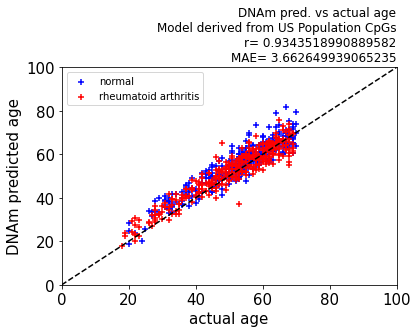

In [247]:
del X_arth

plt.scatter(y_rheu[arth_c0_ind], medium_pop_cpgs_arth_age_pred[arth_c0_ind], label= "normal", marker= "+", color= "blue")
plt.scatter(y_rheu[arth_c1_ind], medium_pop_cpgs_arth_age_pred[arth_c1_ind], color= "red", label= "rheumatoid arthritis", marker= "+")
medium_rheu_pop_cpgs_arthritis_file_name = os.path.join(FIGURES_DIR, "medium_model_us_pop_cpgs_rheu_arthritis_test")
finalize_scatter_plot(
    y_rheu, 
    medium_pop_cpgs_arth_age_pred, 
    "Model derived from US Population CpGs", 
    medium_rheu_pop_cpgs_arthritis_file_name
)

In [248]:
d = {"pred_age": medium_pop_cpgs_arth_age_pred, "actual_age": y_rheu}
d

{'pred_age': array([64.10858188, 49.51464648, 52.39386505, 61.80438113, 36.78630086,
        59.25650833, 71.38995392, 55.38680314, 62.7524076 , 45.77771454,
        36.90736547, 63.28290025, 50.82190055, 47.76694809, 64.5502516 ,
        68.66710218, 71.64328549, 60.18306324, 54.2346157 , 57.28690924,
        53.66058929, 53.76366813, 54.97569   , 51.71061915, 49.50265411,
        58.37740694, 69.79461453, 61.15169087, 62.3489478 , 51.79259897,
        64.76896762, 59.6476792 , 58.71420227, 34.6707112 , 60.72809868,
        52.4873684 , 65.29963358, 58.72516137, 36.00514681, 58.62821336,
        53.06582026, 52.52543491, 44.62823624, 50.05929916, 38.795842  ,
        57.72811456, 36.69896617, 64.91181453, 46.81303452, 59.63181063,
        51.27447733, 37.03992674, 54.44522566, 57.58894847, 51.44104932,
        65.73827906, 64.46914125, 54.23675137, 60.30908415, 61.72254267,
        64.48462211, 70.39724285, 60.28711899, 63.72441171, 42.0004161 ,
        34.08754806, 46.8234017 , 44.61

In [249]:
ds_results = pd.DataFrame(data= d)
ds_results

,pred_age,actual_age
0,64.108582,67.0
1,49.514646,49.0
2,52.393865,53.0
3,61.804381,62.0
4,36.786301,33.0
...,...,...
684,61.314586,63.0
685,57.172824,63.0
686,48.102320,46.0
687,67.447417,64.0


In [250]:
ds_results.to_csv("./arthritis_results_gen_2.csv")

### same for the HIV set

In [251]:
X_HIV_medium = X_HIV[medium_CpG_list]

In [252]:
X_HIV_medium = X_HIV_medium.iloc[:, filtered_cpgs_ints]
len(X_HIV_medium.columns)

139

In [253]:
X_HIV_medium = medium_global_temp_cpgs_scaler.transform(X_HIV_medium)

In [254]:
age_pred_HIV_medium = medium_model_global_temp_cpgs.predict(X_HIV_medium)

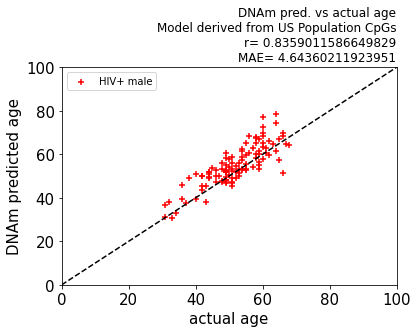

In [255]:
plt.scatter(y_HIV, age_pred_HIV_medium, label= "HIV+ male", marker= "+", color= "red")
medium_HIV_file_name = os.path.join(FIGURES_DIR, "medium_HIV_test_us_pop_derived")
finalize_scatter_plot(y_HIV, age_pred_HIV_medium, "Model derived from US Population CpGs", medium_HIV_file_name)

### Clock trained on random data

In [304]:
medium_data = ["GSE40279"]

In [305]:
medium_X, medium_age = process_data(medium_data)

In [3]:
def randomize_ages(ages):
    min_age = min(ages)
    max_age = max(ages)
    num_ages = len(ages)
    
    return np.random.uniform(low= min_age,
                             high= max_age,
                             size= num_ages)

In [307]:
randomized_ages = randomize_ages(medium_age)
randomized_ages

array([ 45.31254959,  88.28957301,  24.3153557 ,  49.06488874,
        58.197875  ,  50.82078613,  96.73013019,  83.47518797,
        83.14932231,  66.74078284,  87.72780988,  88.46650257,
        55.21584724,  82.85253222,  71.56134511,  72.97209453,
        24.67679782,  25.57574595,  48.24544135,  54.75905576,
        36.99871272,  84.81221556,  38.4055104 ,  82.09669964,
        70.4084824 ,  97.6212557 ,  90.2206389 ,  67.19738885,
        89.96128143,  22.41517026,  98.27829642,  44.51357452,
        66.02427906,  59.01199104,  37.89104152,  57.90443611,
        58.54616819,  26.18370356,  88.59683987,  64.55168837,
        60.31972891,  59.26072623,  58.49441059,  74.56069395,
        43.90044882,  68.60516174,  57.2240708 ,  54.42722569,
        21.47570293,  73.75376391,  55.14240123,  71.4822565 ,
        67.95062456,  99.13275266,  80.81188885,  60.19016118,
        87.71492458,  69.91998578,  25.16398616, 100.30843348,
        92.73749631,  37.9516166 ,  88.6947481 ,  65.58

In [308]:
random_clock_scaler = StandardScaler()

In [309]:
medium_X_random_train, medium_X_random_test, medium_age_random_train, medium_age_random_test = train_test_split(medium_X, randomized_ages, test_size= 0.20)

In [310]:
medium_X_random_train = random_clock_scaler.fit_transform(medium_X_random_train)
medium_X_random_test = random_clock_scaler.transform(medium_X_random_test)

In [311]:
# For the reader's sake, we provide the hyperparameters determined by the following two lines.
# medium_model = model.ElasticNetCV(l1_ratio= [0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99], selection= "random")
# medium_model.fit(medium_X_train, medium_age_train)

# alpha= 0.06470723076032536
# l1_ratio= 0.2

medium_random_model = model.ElasticNet(alpha= 0.06470723076032536, l1_ratio= 0.2)
medium_random_model.fit(medium_X_random_train, medium_age_random_train)

/Users/blanc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+02, tolerance: 2.825e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.06470723076032536, l1_ratio=0.2)

In [312]:
get_number_of_non_zero_coef(medium_random_model)

6439

In [313]:
medium_random_test_predict = medium_random_model.predict(medium_X_random_test)

In [49]:
def finalize_random_scatter_plot(x, y, model_name, file_name):
    r = stats.pearsonr(x, y)[0]
    mae_val = mae(x, y)
    plt.title(f"DNAm pred. vs randomized age\n{model_name}\nr= {r}\nMAE= {mae_val}", loc= "right")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    accuracy_line = [0, 100]
    plt.plot(accuracy_line, accuracy_line, ls= "--", color= "black")
    plt.xlabel("randomized age", fontsize= 15)
    plt.ylabel("DNAm predicted age", fontsize= 15)
    plt.legend()
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 15)
    plt.savefig(fname= f"{file_name}", bbox_inches= "tight", dpi= 600)
    plt.show()

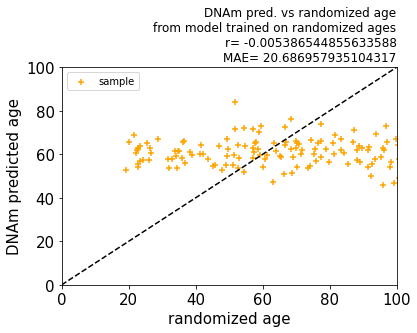

In [334]:
plt.scatter(medium_age_random_test, medium_random_test_predict, label= "sample", marker= "+", color="orange")
medium_random_file_name = os.path.join(FIGURES_DIR, "medium_model_random_ages_test")
finalize_random_scatter_plot(medium_age_random_test, medium_random_test_predict, "model trained on randomized ages", medium_random_file_name)

### let's see what happens if our methylation data is completely random

In [316]:
def randomize_methylation_profile(X):
    return np.random.uniform(size= X.shape)

In [317]:
medium_data = ["GSE40279"]

In [318]:
medium_X, medium_age = process_data(medium_data)

In [319]:
medium_random_methyl_X = randomize_methylation_profile(medium_X)

In [320]:
random_methyl_X_scaler = StandardScaler()

In [321]:
medium_random_methyl_X_train, medium_random_methyl_X_test, medium_random_methyl_age_train, medium_random_methyl_age_test = train_test_split(medium_random_methyl_X, medium_age, test_size= 0.20)

In [322]:
medium_random_methyl_X_train = random_clock_scaler.fit_transform(medium_random_methyl_X_train)
medium_random_methyl_X_test = random_clock_scaler.transform(medium_random_methyl_X_test)

In [323]:
# For the reader's sake, we provide the hyperparameters determined by the following two lines.
# medium_model = model.ElasticNetCV(l1_ratio= [0.05, 0.1, 0.2, 0.4, 0.7, 0.85, 0.99], selection= "random")
# medium_model.fit(medium_X_train, medium_age_train)

# alpha= 0.06470723076032536
# l1_ratio= 0.2

medium_random_methyl_model = model.ElasticNet(alpha= 0.06470723076032536, l1_ratio= 0.2)
medium_random_methyl_model.fit(medium_random_methyl_X_train, medium_random_methyl_age_train)

/Users/blanc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.664e+01, tolerance: 1.060e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.06470723076032536, l1_ratio=0.2)

In [324]:
get_number_of_non_zero_coef(medium_random_methyl_model)

4062

In [325]:
medium_random_methyl_test_predict = medium_random_methyl_model.predict(medium_random_methyl_X_test)

In [331]:
def finalize_random_methyl_scatter_plot(x, y, model_name, file_name):
    r = stats.pearsonr(x, y)[0]
    mae_val = mae(x, y)
    plt.title(f"DNAm pred. vs actual age\nfrom {model_name}\nr= {r}\nMAE= {mae_val}", loc= "right")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    accuracy_line = [0, 100]
    plt.plot(accuracy_line, accuracy_line, ls= "--", color= "black")
    plt.xlabel("actual age (randomized methylation profile)", fontsize= 12)
    plt.ylabel("DNAm predicted age", fontsize= 12)
    plt.legend()
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 15)
    plt.savefig(fname= f"{file_name}", bbox_inches= "tight", dpi= 600)
    plt.show()

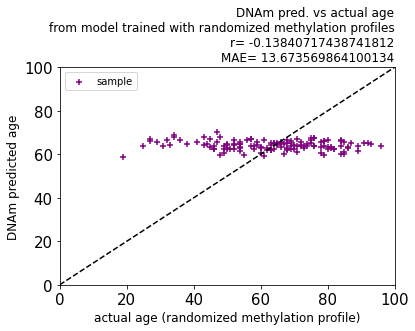

In [333]:
plt.scatter(medium_random_methyl_age_test, medium_random_methyl_test_predict, label= "sample", marker= "+", color="purple")
medium_random_methyl_file_name = os.path.join(FIGURES_DIR, "medium_random_methyl_model_test")
random_methyl_plot_title = "model trained with randomized methylation profiles"
finalize_random_methyl_scatter_plot(medium_random_methyl_age_test, medium_random_methyl_test_predict, random_methyl_plot_title, medium_random_methyl_file_name)

### Let's make an age predictor that uses song and movie titles as its data

In [96]:
top_songs_by_half_decade = {
    (2015, 2019): "Shape Of You, Ed Sheeran",
    (2010, 2014): "Call Me Maybe, Carly Rae Jepsen",
    (2005, 2009): "Single Ladies (Put a Ring on It), Beyonce",
    (2000, 2004): "Lose Yourself, Eminem",
    (1995, 1999): "Macarena (Bayside Boys Mix), Los Del Rio",
    (1990, 1994): "U2, One",
    (1985, 1989): "Guns N' Roses, Sweet Child O' Mine",
    (1980, 1984): "Beat It, Michael Jackson",
    (1975, 1979): "Stayin' Alive, Bee Gees",
    (1970, 1974): "Superstition, Stevie Wonder",
    (1965, 1969): "Marvin Gaye, I Heard It Through the Grapevine",
    (1960, 1964): "The House of the Rising Sun, The Animals",
    (1955, 1959): "Johny B. Goode, Chuck Berry",
    (1950, 1954): "Tennessee Waltz, Patti Page",
    (1945, 1949): "Rudolph, the Red-Nosed Reindeer; Gene Autry",
    (1940, 1944): "When You Wish Upon a Star, Cliff Edwards",
    (1935, 1939): "In the Mood, Glenn Miller",
    (1930, 1934): "Stormy Weather (Keeps Rainin' All the Time), Ethel Waters",
    (1925, 1929): "My Blue Heaven, Gene Austin",
    (1920, 1924): "April Showers, Al Jolson",
    (1915, 1919): "After You've Gone, Marion Harris",
    (1910, 1914): "Some of These Days, Sophie Tucker"
}

In [97]:
top_movies_by_year = {
    2022: "Top Gun: Maverick",
    2021: "Spider-Man: No Way Home",
    2020: "The Eight Hundred",
    2019: "Avengers: Endgame",
    2018: "Avengers: Infinity War",
    2017: "Star Wars: Episode VIII - The Last Jedi",
    2016: "Captain America: Civil War",
    2015: "Star Wars: Episode VII - The Force Awakens",
    2014: "Transformers: Age of Extinction",
    2013: "Frozen",
    2012: "The Avengers",
    2011: "Harry Potter and the Deathly Hallows: Part 2",
    2010: "Toy Story 3",
    2009: "Avatar",
    2008: "The Dark Knight",
    2007: "Pirates of the Caribbean: At World's End",
    2006: "Pirates of the Caribbean: Dead Man's Chest",
    2005: "Harry Potter and the Goblet of Fire",
    2004: "Shrek 2",
    2003: "The Lord of the Rings: The Return of the King",
    2002: "The Lord of the Rings: The Two Towers",
    2001: "Harry Potter and the Sorcerer's Stone",
    2000: "Mission Impossible II",
    1999: "Star Wars: Episode I - The Phantom Menace",
    1998: "Armageddon",
    1997: "Titanic",
    1996: "Independence Day",
    1995: "Die Hard: With a Vengeance",
    1994: "The Lion King",
    1993: "Jurassic Park",
    1992: "Aladdin",
    1991: "Terminator 2: Judgement Day",
    1990: "Ghost",
    1989: "Indiana Jones and the Last Crusade",
    1988: "Rain Man",
    1987: "Fatal Attraction",
    1986: "Top Gun",
    1985: "Back to the Future",
    1984: "Indiana Jones and the Temple of Doom",
    1983: "Star Wars: Episode VI - Return of the Jedi",
    1982: "E.T. - The Extra Terrestial",
    1981: "Raiders of the Lost Arc",
    1980: "Star Wars: Episode V - The Empire Strikes Back",
    1979: "Moonraker",
    1978: "Grease",
    1977: "Star Wars: Episode IV - A New Hope",
    1976: "Rocky",
    1975: "Jaws",
    1974: "Blazing Saddles",
    1973: "The Exorcist",
    1972: "The Godfather",
    1971: "Billy Jack",
    1970: "Love Story",
    1969: "Butch Cassidy and the Sundance Kid",
    1968: "Funny Girl",
    1967: "The Jungle Book",
    1966: "The Bible: In the Beginning...",
    1965: "The Sound of Music",
    1964: "Mary Poppins",
    1963: "Cleopatra",
    1962: "The Longest Day",
    1961: "101 Dalmations",
    1960: "Swiss Family Robinson",
    1959: "Ben-Hur",
    1958: "South Pacific",
    1957: "The Bridge on the River Kwai",
    1956: "The Ten Commandments",
    1955: "Lady and the Tramp",
    1954: "White Christmas",
    1953: "Peter Pan",
    1952: "The Greatest Snow on Earth",
    1951: "Quo Vadis?",
    1950: "Cinderalla",
    1949: "Samson and Delilah",
    1948: "The Snake Pit",
    1947: "Forever Amber",
    1946: "Song of the South",
    1945: "The Bells of St. Mary's",
    1944: "Going My Way",
    1943: "This is the Army",
    1942: "Bambi",
    1941: "Sergeant York",
    1940: "Pinocchio",
    1939: "Gone With the Wind",
    1938: "Alexander's Ragtime Band",
    1937: "Snow White and the Seven Dwarfs",
    1936: "One in a Million",
    1935: "Top Hat",
    1934: "It Happened One Night",
    1933: "King Kong",
    1932: "Shanghai Express",
    1931: "Frankenstein",
    1930: "Tom Sawyer",
    1929: "The Broadway Melody",
    1928: "The Road to Ruin",
    1927: "The Jazz Singer",
    1926: "Aloma of the South Seas",
    1925: "The Big Parade",
    1924: "The Thief of Baghdad",
    1923: "The Covered Wagon",
    1922: "Robin Hood",
    1921: "The Four Horsemen of the Apocalypse",
    1920: "Way Down East",
    1919: "The Miracle Man",
    1918: "Mickey",
    1917: "A Romance of the Redwoods",
    1916: "Joan the Woman",
    1915: "The Birth of a Nation"
}

### let's assign the titles to each age

In [98]:
def convert_to_movie_titles(ages, publish_year):
    movie_titles = []
    for a in ages:
        birth_year = a - publish_year
        age_linked_movie = top_movies_by_year[birth_year]
        movie_titles.append(age_linked_movie)
        
    return movie_titles

In [99]:
medium_X, medium_age = process_data(medium_data)

In [100]:
gse40279_publish_year = 2012
medium_movie_titles = convert_to_movie_titles(medium_age, gse40279_publish_year)

KeyError: -1945.0

### now let's actually assign numerical scores to each metric

In [394]:
movie_title_scores = dict()
for y in list(top_movies_by_year):
    movie_title_scores[top_movies_by_year[y]] = (2023 - y) / 10
movie_title_scores

{'Top Gun: Maverick': 0.1,
 'Spider-Man: No Way Home': 0.2,
 'The Eight Hundred': 0.3,
 'Avengers: Endgame': 0.4,
 'Avengers: Infinity War': 0.5,
 'Star Wars: Episode VIII - The Last Jedi': 0.6,
 'Captain America: Civil War': 0.7,
 'Star Wars: Episode VII - The Force Awakens': 0.8,
 'Transformers: Age of Extinction': 0.9,
 'Frozen': 1.0,
 'The Avengers': 1.1,
 'Harry Potter and the Deathly Hallows: Part 2': 1.2,
 'Toy Story 3': 1.3,
 'Avatar': 1.4,
 'The Dark Knight': 1.5,
 "Pirates of the Caribbean: At World's End": 1.6,
 "Pirates of the Caribbean: Dead Man's Chest": 1.7,
 'Harry Potter and the Goblet of Fire': 1.8,
 'Shrek 2': 1.9,
 'The Lord of the Rings: The Return of the King': 2.0,
 'The Lord of the Rings: The Two Towers': 2.1,
 "Harry Potter and the Sorcerer's Stone": 2.2,
 'Mission Impossible II': 2.3,
 'Star Wars: Episode I - The Phantom Menace': 2.4,
 'Armageddon': 2.5,
 'Titanic': 2.6,
 'Independence Day': 2.7,
 'Die Hard: With a Vengeance': 2.8,
 'The Lion King': 2.9,
 'Jur

In [395]:
song_title_scores = dict()
for y in list(top_songs_by_half_decade):
    avg_year = (y[0] + y[1]) / 2
    song_title_scores[top_songs_by_half_decade[y]] = (2023 - avg_year) / 10
song_title_scores

{'Shape Of You, Ed Sheeran': 0.6,
 'Call Me Maybe, Carly Rae Jepsen': 1.1,
 'Single Ladies (Put a Ring on It), Beyonce': 1.6,
 'Lose Yourself, Eminem': 2.1,
 'Macarena (Bayside Boys Mix), Los Del Rio': 2.6,
 'U2, One': 3.1,
 "Guns N' Roses, Sweet Child O' Mine": 3.6,
 'Beat It, Michael Jackson': 4.1,
 "Stayin' Alive, Bee Gees": 4.6,
 'Superstition, Stevie Wonder': 5.1,
 'Marvin Gaye, I Heard It Through the Grapevine': 5.6,
 'The House of the Rising Sun, The Animals': 6.1,
 'Johny B. Goode, Chuck Berry': 6.6,
 'Tennessee Waltz, Patti Page': 7.1,
 'Rudolph, the Red-Nosed Reindeer; Gene Autry': 7.6,
 'When You Wish Upon a Star, Cliff Edwards': 8.1,
 'In the Mood, Glenn Miller': 8.6,
 "Stormy Weather (Keeps Rainin' All the Time), Ethel Waters": 9.1,
 'My Blue Heaven, Gene Austin': 9.6,
 'April Showers, Al Jolson': 10.1,
 "After You've Gone, Marion Harris": 10.6,
 'Some of These Days, Sophie Tucker': 11.1}

In [396]:
def get_top_song_for_year(year):
    year = int(year)
    print(year)
    for y_range in list(top_songs_by_half_decade):
        if year >= y_range[0] and year <= y_range[1]:
            return top_songs_by_half_decade[y_range]

In [397]:
def get_raw_song_and_movie_score(age, publishing_year):
    birth_year = publishing_year - age
    
    top_song_at_birth = get_top_song_for_year(birth_year)
    top_movie_at_birth = top_movies_by_year[birth_year]
    
    song_score = song_title_scores[top_song_at_birth]
    movie_score = movie_title_scores[top_movie_at_birth]
    
    return song_score, movie_score

In [413]:
get_raw_song_and_movie_score(22, 2012)

1990


(3.1, 3.3)

In [414]:
def get_predicted_age_from_song_and_movie_score(song_and_movie_score):
    return 5 * song_and_movie_score[0] + 5 * song_and_movie_score[1] - 10

In [415]:
get_predicted_age_from_song_and_movie_score((2.1, 2.2))

11.5

In [416]:
def get_predicted_age_from_age(age, publishing_year):
    song_and_movie_score = get_raw_song_and_movie_score(age, publishing_year)
    return get_predicted_age_from_song_and_movie_score(song_and_movie_score)

In [417]:
get_predicted_age_from_age(22, 2012)

1990


22.0

In [418]:
song_movie_pred_ages = []
ignored_ages_indices = []
for a in medium_age:
    if a >= 97:
        song_movie_pred_ages.append(-1)
        continue
    pred_age = get_predicted_age_from_age(int(a), gse40279_publish_year)
    song_movie_pred_ages.append(pred_age)

song_movie_pred_ages

1945
1923
1946
1948
1950
1925
1939
1937
1939
1929
1930
1964
1935
1958
1949
1941
1944
1932
1920
1952
1933
1944
1919
1928
1938
1938
1936
1956
1940
1937
1933
1939
1930
1938
1933
1958
1933
1928
1927
1925
1938
1935
1939
1925
1927
1924
1946
1934
1959
1936
1945
1939
1958
1939
1916
1955
1936
1965
1958
1939
1928
1950
1923
1944
1950
1933
1940
1943
1957
1939
1933
1940
1923
1933
1927
1944
1923
1939
1949
1934
1947
1947
1923
1927
1946
1936
1938
1928
1941
1963
1943
1949
1946
1927
1936
1928
1953
1942
1947
1944
1928
1937
1961
1949
1943
1934
1934
1960
1963
1959
1953
1950
1966
1944
1938
1953
1936
1958
1953
1964
1967
1950
1949
1932
1952
1941
1945
1962
1926
1942
1958
1943
1936
1954
1954
1948
1939
1963
1956
1937
1964
1931
1940
1951
1962
1943
1947
1965
1969
1957
1958
1954
1978
1947
1960
1980
1965
1958
1949
1984
1958
1953
1956
1962
1982
1962
1965
1965
1979
1974
1977
1965
1932
1926
1941
1935
1945
1928
1932
1942
1945
1949
1942
1956
1945
1942
1942
1938
1939
1935
1932
1946
1927
1936
1934
1930
1936
1941
1930
1929


[67.0,
 90.5,
 66.5,
 65.5,
 62.0,
 87.0,
 75.0,
 76.0,
 75.0,
 85.0,
 82.0,
 50.0,
 77.0,
 55.5,
 65.0,
 71.5,
 70.0,
 81.0,
 92.0,
 61.0,
 80.5,
 70.0,
 95.0,
 85.5,
 75.5,
 75.5,
 76.5,
 56.5,
 72.0,
 76.0,
 80.5,
 75.0,
 82.0,
 75.5,
 80.5,
 55.5,
 -1,
 80.5,
 85.5,
 86.0,
 87.0,
 75.5,
 77.0,
 75.0,
 87.0,
 86.0,
 90.0,
 66.5,
 80.0,
 55.0,
 76.5,
 67.0,
 75.0,
 55.5,
 75.0,
 96.5,
 57.0,
 76.5,
 47.0,
 55.5,
 75.0,
 85.5,
 62.0,
 90.5,
 70.0,
 62.0,
 80.5,
 72.0,
 70.5,
 56.0,
 75.0,
 80.5,
 72.0,
 90.5,
 80.5,
 86.0,
 70.0,
 90.5,
 75.0,
 65.0,
 80.0,
 66.0,
 66.0,
 90.5,
 86.0,
 66.5,
 76.5,
 75.5,
 85.5,
 71.5,
 50.5,
 70.5,
 65.0,
 66.5,
 86.0,
 76.5,
 85.5,
 60.5,
 71.0,
 66.0,
 70.0,
 85.5,
 76.0,
 51.5,
 65.0,
 70.5,
 80.0,
 80.0,
 52.0,
 50.5,
 55.0,
 60.5,
 62.0,
 46.5,
 70.0,
 75.5,
 60.5,
 76.5,
 55.5,
 60.5,
 50.0,
 46.0,
 62.0,
 65.0,
 81.0,
 61.0,
 71.5,
 67.0,
 51.0,
 86.5,
 71.0,
 55.5,
 70.5,
 76.5,
 60.0,
 60.0,
 65.5,
 75.0,
 50.5,
 56.5,
 76.0,
 50.0,
 81.5,
 

In [422]:
def finalize_song_movie_scatter_plot(x, y, model_name, file_name):
    r = stats.pearsonr(x, y)[0]
    mae_val = mae(x, y)
    plt.title(f"DNAm pred. vs actual age\n{model_name}\nr= {r}\nMAE= {mae_val}", loc= "right")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    accuracy_line = [0, 100]
    plt.plot(accuracy_line, accuracy_line, ls= "--", color= "black")
    plt.xlabel("actual age", fontsize= 10)
    plt.ylabel("Childhood most popular song\nand movie predicted age", fontsize= 10)
    plt.legend()
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 15)
    plt.savefig(fname= f"{file_name}", bbox_inches= "tight", dpi= 600)
    plt.show()

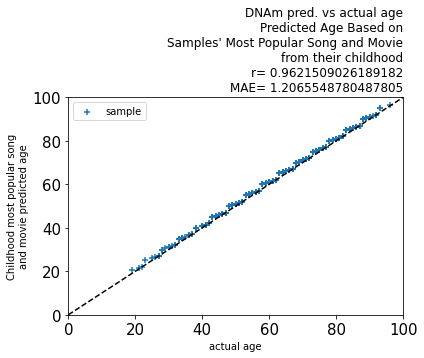

In [424]:
plt.scatter(medium_age, song_movie_pred_ages, label= "sample", marker= "+")
song_movie_file_name = os.path.join(FIGURES_DIR, "song_movie_pred")
finalize_song_movie_scatter_plot(medium_age, song_movie_pred_ages, "Predicted Age Based on\nSamples' Most Popular Song and Movie\nfrom their childhood", song_movie_file_name)